In [9]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import tables
import datetime
from digicamscheduling.utils import time
from astropy.coordinates import EarthLocation
from digicamscheduling.io import reader
import astropy.time
import dateutil.parser
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
plt.style.use('dark_background')
from matplotlib import rcParams
import matplotlib.font_manager as font_manager
font_path = '/home/users/l/lacave/fonts/Outfit-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Outfit'

In [10]:
visibility_dir = '/home/users/l/lacave/PhD/Analysis/SourceSensitivity/LHAASOVisibility'

# IRFs

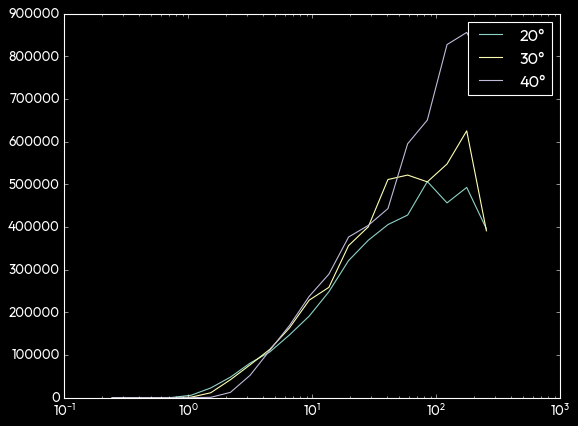

In [11]:
IRF20_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/IRFs/data/sst1m_stereo/0_4/bcf/ze20_az180_nsb100_gc0.75/SST1M_stereo_Zen20deg_gcut0.75_irfs.fits"
IRF30_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/IRFs/data/sst1m_stereo/0_4/bcf/ze30_az180_nsb100_gc0.75/SST1M_stereo_Zen30deg_gcut0.75_irfs.fits"
IRF40_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/IRFs/data/sst1m_stereo/0_4/bcf/ze40_az180_nsb100_gc0.75/SST1M_stereo_Zen40deg_gcut0.75_irfs.fits"

hdul = fits.open(IRF20_file)
effA20table = hdul["EFFECTIVE AREA"]
effA20 = effA20table.data['EFFAREA'][0][1]
dE = effA20table.data['ENERG_HI'][0] - effA20table.data['ENERG_LO'][0]
EeffA = (effA20table.data['ENERG_HI'][0] + effA20table.data['ENERG_LO'][0])/2
hdul.close()

hdul = fits.open(IRF30_file)
effA20table = hdul["EFFECTIVE AREA"]
effA30 = effA20table.data['EFFAREA'][0][1]
# dE20 = effA20table.data['ENERG_HI'][0] - effA20table.data['ENERG_LO'][0]
EeffA = (effA20table.data['ENERG_HI'][0] + effA20table.data['ENERG_LO'][0])/2
hdul.close()

hdul = fits.open(IRF40_file)
effA20table = hdul["EFFECTIVE AREA"]
effA40 = effA20table.data['EFFAREA'][0][0]
# dE20 = effA20table.data['ENERG_HI'][0] - effA20table.data['ENERG_LO'][0]
EeffA = (effA20table.data['ENERG_HI'][0] + effA20table.data['ENERG_LO'][0])/2
hdul.close()

plt.plot(EeffA, effA20, label="20°")
plt.plot(EeffA, effA30, label="30°")
plt.plot(EeffA, effA40, label="40°")
plt.legend()
plt.xscale('log')
# plt.close()
# plt.plot(dE)
# print(dE)
# plt.yscale('log')

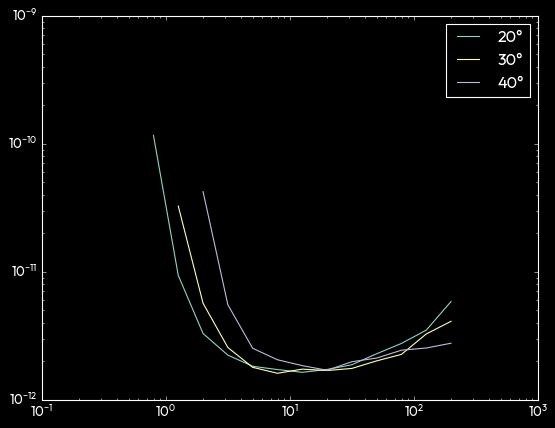

In [12]:
sens20_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/sensitivity/stereo_performance_20deg_efficiency_psf_vaod0.2/flux_sensitivity_stereo.h5"
sens30_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/sensitivity/stereo_performance_30deg_efficiency_psf_vaod0.2/flux_sensitivity_stereo.h5"
sens40_file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/IRFs/sensitivity/stereo_performance_40deg_efficiency_psf_vaod0.2/flux_sensitivity_stereo.h5"

with pd.HDFStore(sens20_file) as f:
    # print(f.sensitivity)
    SST1M_Sensitivity20 = f.sensitivity["flux_sensitivity"]
    SST1M_Energy20 = f.sensitivity["energy"]
    mean_sens = np.mean(f.sensitivity["energy"])

with pd.HDFStore(sens30_file) as f:
    # print(f.sensitivity)
    SST1M_Sensitivity30 = f.sensitivity["flux_sensitivity"]
    SST1M_Energy30 = f.sensitivity["energy"]
    mean_sens = np.mean(f.sensitivity["energy"])

with pd.HDFStore(sens40_file) as f:
    # print(f.sensitivity)
    SST1M_Sensitivity40 = f.sensitivity["flux_sensitivity"]
    SST1M_Energy40 = f.sensitivity["energy"]
    mean_sens = np.mean(f.sensitivity["energy"])

plt.plot(SST1M_Energy20, SST1M_Sensitivity20, label="20°")
plt.plot(SST1M_Energy30, SST1M_Sensitivity30, label="30°")
plt.plot(SST1M_Energy40, SST1M_Sensitivity40, label="40°")
plt.legend()
plt.xscale('log')
plt.yscale('log')

# LHAASO

In [13]:
#Load json catalog
file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/catalog/LHAASO_SST1M.json"
# file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivity/HAWC_Catalog/LHAASO.json"
with open(file, encoding="utf-8-sig") as f:
    sources = json.load(f)
gammacat = pd.DataFrame(sources['sources'])
# gammacat = pd.read_csv("/home/users/l/lacave/PhD/Analysis/SourceSensitivity/HAWC_Catalog/LHAASO_SST1M.csv")
# gammacat['other'] = [x.replace(' ','') for x in gammacat['other']]
print(len(gammacat.index))
print(gammacat.columns)
# print([x.replace(' ','') for x in gammacat['other']])

24
Index(['name', 'ra', 'dec', 'weight', 'other', 'flux', 'flux_at', 'galactic',
       'type'],
      dtype='object')


Text(0, 0.5, 'Significance')

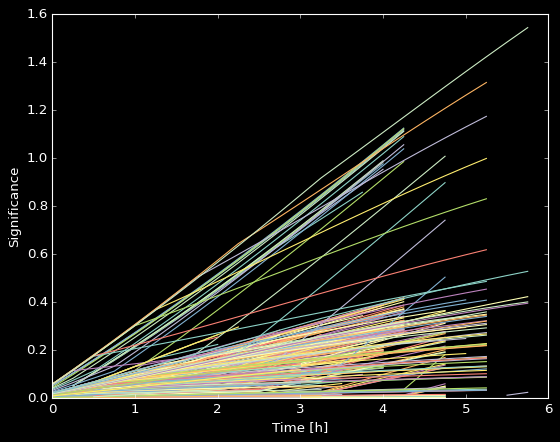

In [24]:
m = 7
last = 31
year = 2024
file = "/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/catalog/LHAASO.csv"
data = pd.read_csv(file)
E =np.arange(0.1, 30, 0.1) # SST1M_Energy40 #np.arange(0.1, 10.1, 0.1)
# print(E)
sigmas = {}

for d in range(1, last+1, 1):
    gammacat.loc[:,f"N_events_{d:02d}"] = 0
    # visibility_df = pd.DataFrame(columns=['name', 'integral_visibility'])
    for src in gammacat['name']:
        s = src.replace(" ", "")
        if d < last:
            f = f"{visibility_dir}/{s}_{year}-{m:02d}-{d:02d}T12-00-00.000_{year}-{m:02d}-{d+1:02d}T12-00-00.000_visibility.csv"
        else:
            f = f"{visibility_dir}/{s}_{year}-{m:02d}-{d:02d}T12-00-00.000_{year}-{m+1:02d}-01T12-00-00.000_visibility.csv"
        visibility_df_temp = pd.read_csv(f, index_col=False)
        # visibility_df_temp.replace(0.0, np.nan, inplace=True)        
        # above40elevation = visibility_df_temp['elevation'][visibility_df_temp['elevation'] > 40].to_numpy()
        med_el = visibility_df_temp['elevation'][visibility_df_temp['elevation'] > 40].median()
        # print(len(above40elevation))
        # if len(above40elevation) > 0:
        #     med_el = np.median(above40elevation)
        # else:
        #     med_el = 0
        if med_el < 50:
            effA = np.interp(E, EeffA, effA40)
            sens = np.interp(E, SST1M_Energy40, SST1M_Sensitivity40)/E**2
        elif med_el < 65:
            effA = np.interp(E, EeffA, effA30)
            sens = np.interp(E, SST1M_Energy30, SST1M_Sensitivity30)/E**2
        else:
            effA = np.interp(E, EeffA, effA20)
            sens = np.interp(E, SST1M_Energy20, SST1M_Sensitivity20)/E**2
        if med_el > 40:# & len(above40elevation) >= 8:
            N0 = data['N0'][(data['components'] == 'WCDA') & (data['Source name']==src)].to_numpy()[0]
            index = data['index'][(data['components'] == 'WCDA') & (data['Source name']==src)].to_numpy()[0]
            dNdE = N0 * 1e-13 * (E/3)**-index
            dE = 0.1
            dt = 900 #s (15min)
            V = visibility_df_temp['source_visibility']
            V = V.astype('float')
            # print(relative_sens)
            N_events = np.nansum(np.nansum(dNdE*effA*10000*dE)*V)*dt
            relative_sens = np.nansum(dNdE / sens) / np.nansum(sens / sens) * 5/50
            # relative_sens = np.mean(dNdE / sens) * 5/50
            # print(sens / sens)
            sigma = []
            intsigma = 0
            for i in range(len(V)):
                intsigma += relative_sens * V[i]*dt/3600# * 7
                if V[i] == 0:
                    sigma.append(np.nan)
                else:
                    sigma.append(intsigma)
            # print(len(V), sigma)
            sigmas[f"sigma{s}{d}"] = sigma
            plt.plot(np.arange(len(sigma))*15/60, sigma)
            # plt.scatter(s,relative_sens)
            # plt.plot(E, dNdE / sens)
            # plt.axhline(np.mean(dNdE / sens), color='w')
            # print(relative_sens, sigma)
        else:
            integr = 0
            N_events = 0
        # gammacat.loc[gammacat['name'] == src, f"integral_visibility_{d:02d}"] = integr
        gammacat.loc[gammacat['name'] == src, f"N_events_{d:02d}"] = N_events
# plt.xscale('log')
# plt.yscale('log')
# plt.axhline(1, color='w')
plt.xlabel('Time [h]')
plt.ylabel('Significance')

In [25]:
def plots_LHAASO(data, month, last=31):   
    visibleSources = pd.read_csv("/home/users/l/lacave/PhD/Analysis/SourceSensitivitySST1M/catalog/LHAASO_SST1M.csv") 
    data.sort_values('flux', inplace=True, ascending=False)
    coordinates = reader.read_location(filename="/home/users/l/lacave/PhD/digicamscheduling/digicamscheduling/config/digicamextra/location_ondrejov.txt")
    location = EarthLocation(**coordinates)
    colors=["#9e0142", "#f46d43", "#fee08b", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#f0369f"]
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', "August", 'September', 'October', 'November', "December"]
    
    for i in range(1, last +1, 1):
        cols = ['name','other', 'ra', 'dec',  f"N_events_{i:02d}", "galactic", "type"] #'flux', 'flux_at',
        max_vis_E_df = data
        max_vis_E_df['weigted_visibility'] = max_vis_E_df[f"N_events_{i:02d}"]# * max_vis_E_df['integrated_flux']
        max_vis_E_df = data[data['name'].isin(visibleSources['name'])]
        fig, axs = plt.subplots(nrows=5, figsize=(12, 17))
        ax = fig.add_subplot(522, projection="mollweide")
        ax.grid(color='gray', zorder=0)
        m = 0
        c = 0
        cellColors = []
        idx = 0
        max_vis_E_df = max_vis_E_df[max_vis_E_df[f'N_events_{i:02d}'] > 0]
        # print(len(max_vis_E_df))
        max_vis_E_df.sort_values('weigted_visibility', inplace=True, ascending=False)
    
        for index, row in max_vis_E_df.iterrows():
            color = colors[c%8]
            cellColors.append([color] * len(cols))
            n = row['name']
            s = n.replace(" ", "")
            if i == last:
                f = f"{visibility_dir}/{s}_{year}-{month:02d}-{i:02d}T12-00-00.000_{year}-{month+1:02d}-01T12-00-00.000_visibility.csv"
                # bools = quand_LHAASO(s, i, row['flux'], SST1M_Sensitivity[7],)
                visibility_df_temp = pd.read_csv(f, index_col=False)
                visibility_df_temp.replace(0.0, np.nan, inplace=True)
                dt = dateutil.parser.parse(f"'2024-{month:02d}-{i:02d} 12:00'")
                start_date = astropy.time.Time(dt)
                dt = dateutil.parser.parse(f"'2024-{month+1:02d}-01 12:00'")
                end_date = astropy.time.Time(dt)
            else:
                f = f"{visibility_dir}/{s}_{year}-{month:02d}-{i:02d}T12-00-00.000_{year}-{month:02d}-{i+1:02d}T12-00-00.000_visibility.csv"
                # print(f)
                # bools = quand_LHAASO(s, i, row['flux'], SST1M_Sensitivity[7])
                visibility_df_temp = pd.read_csv(f, index_col=False)
                visibility_df_temp.replace(0.0, np.nan, inplace=True)
                dt = dateutil.parser.parse(f"'2024-{month:02d}-{i:02d} 12:00'")
                start_date = astropy.time.Time(dt)
                dt = dateutil.parser.parse(f"'2024-{month:02d}-{i+1:02d} 12:00'")
                end_date = astropy.time.Time(dt)

            date = time.compute_time(date_start=start_date, date_end=end_date,
                                time_step=15*u.min, location=location,
                                only_night=True)
            # print(row['weight'])
            # print(bools)
            # vis = np.array([a * b for a, b in zip(visibility_df_temp['source_visibility'], bools)] * row['weight'])
            vis = visibility_df_temp['source_visibility']
            vis = vis.astype('float')
            # vis[vis == 0.] = np.nan
            # print(vis)
            # el = np.array([a * b for a, b in zip(visibility_df_temp['elevation'], bools)])
            el = visibility_df_temp['elevation']
            el = el.astype('float')
            el[el < 40] = np.nan
            # el[el == 0.] = np.nan
            # print(el)
            axs[3].plot_date(date.plot_date, vis, label=n, color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            # print(date.plot_date)
            axs[3].set_xlabel('UTC time')
            axs[4].plot_date(date.plot_date, el, color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            axs[4].set_xlabel('UTC time')
            axs[2].plot_date(date.plot_date, np.sqrt(sigmas[f"sigma{s}{i}"]), color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            # axs[2].plot_date(date.plot_date, visibility_df_temp['source_visibility'] * row['integrated_flux'], label=n, color=color, alpha=1, markeredgewidth=0.0, markersize=len(max_vis_E_df)-idx +5, zorder=idx)
            axs[2].set_xlabel('UTC time')

            c_icrs = SkyCoord(ra=row['ra']*u.degree, dec=row['dec']*u.degree, frame='icrs')
            # if row['r39']>0:
            #     ax.scatter(-c_icrs.galactic.l.wrap_at('180d').radian, c_icrs.galactic.b.wrap_at('180d').radian, color=color, alpha=1, zorder=idx, s=row['r39']*70+30)
            # else:
            #     ax.scatter(-c_icrs.galactic.l.wrap_at('180d').radian, c_icrs.galactic.b.wrap_at('180d').radian, color=color, alpha=1, zorder=idx, marker="x", s=40)
            c+=1
            idx+=1
        axs[3].legend(bbox_to_anchor=(0.3, 4))
        axs[3].set_ylabel('Visibility')
        axs[3].grid(zorder=0)
        axs[3].axes.xaxis.set_ticklabels([])
        axs[2].axes.xaxis.set_ticklabels([])
        axs[3].set_ylim(bottom=0, top=1)
        axs[4].set_ylim((40, 90))
        axs[2].set_ylim(bottom=0)
        axs[3].set_xlabel(None)
        axs[2].set_xlabel(None)
        axs[4].set_ylabel('Elevation [deg]')
        axs[4].grid(zorder=0)
        # axs[2].axhline(SST1M_Sensitivity[7], lw=2, color='k')
        # axs[2].set_ylabel(f"Visible FLux at {max_vis_E_df['flux_at'].to_numpy()[0]}TeV [TeV/cm$^2$/s]")
        axs[2].set_ylabel(f"Indicative Significance")
        axs[2].grid(zorder=0)
        axs[4].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[4].xaxis.get_major_locator()))
        # axs[2].text()

        

        plt.style.use('classic')
        df_temp = max_vis_E_df[cols]
        df_temp.update(df_temp[['ra', 'dec',f"N_events_{i:02d}"]].astype(float))
        df_temp.update(df_temp[['ra', 'dec', f"N_events_{i:02d}"]].applymap('{:.2E}'.format))
        if len(df_temp)>0:
            table = axs[1].table(cellText=df_temp.values, colLabels=df_temp.columns, loc='center', cellColours=cellColors, alpha=0.1,)
            table.auto_set_font_size(False)
            table.set_fontsize(12)
            table.scale(0.8, 1.2)
            table.auto_set_column_width(col=list(range(len(df_temp.columns))))
        plt.style.use('dark_background')
        # hide axes
        # fig.patch.set_visible(False)
        axs[0].axis('off')
        axs[0].axis('tight')
        axs[1].axis('off')
        axs[1].axis('tight')
        # axs[0].set_title(f"{months[i-1]} 2024", fontsize= 24)
        plt.subplots_adjust(wspace=0, hspace=0)
        # plt.tight_layout()
        # plt.savefig(f"/home/users/l/lacave/PhD/Analysis/SourceSensitivity/BL/BL_{months[i-1]}.pdf", dpi=330)
        plt.show()
        # max_vis_E_df[['name', 'E_WCDA', 'E_KM2A', 'ra', 'dec', 'r39', f"mean_visibility_{i:02d}", "Assoc.(Sep.)"]].to_csv(f"/home/users/l/lacave/PhD/Analysis/SourceSensitivity/visibility/sources_{i:02d}.csv")
        m+=1
        # print(max_vis_E_df[['name', 'E_WCDA', 'E_KM2A', 'ra', 'dec', 'N0']])

## Plots

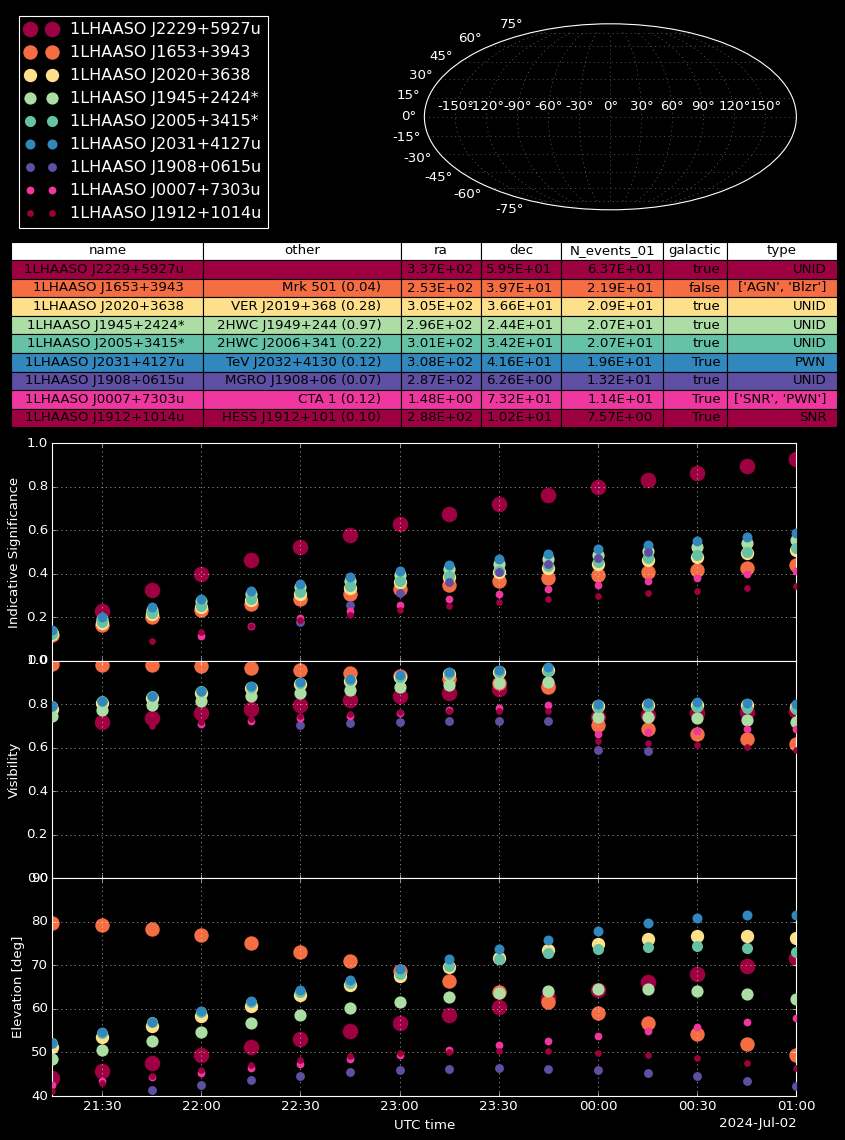

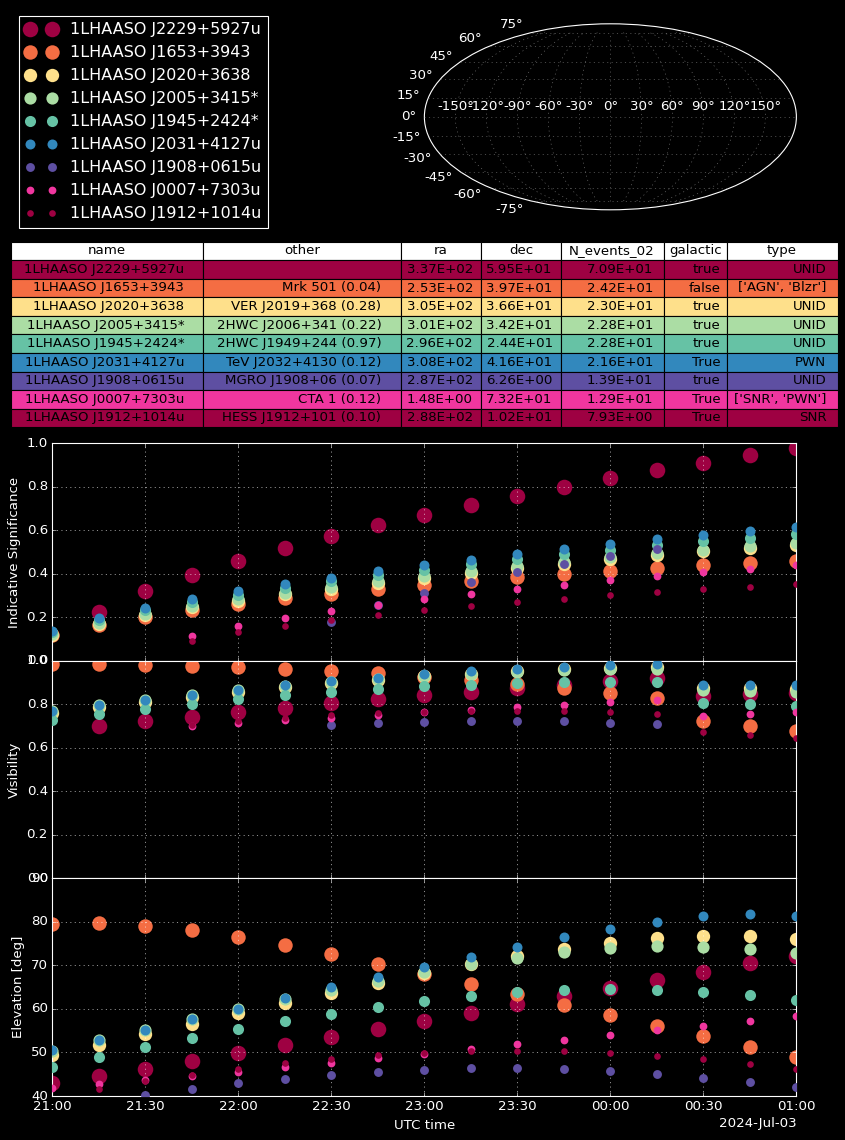

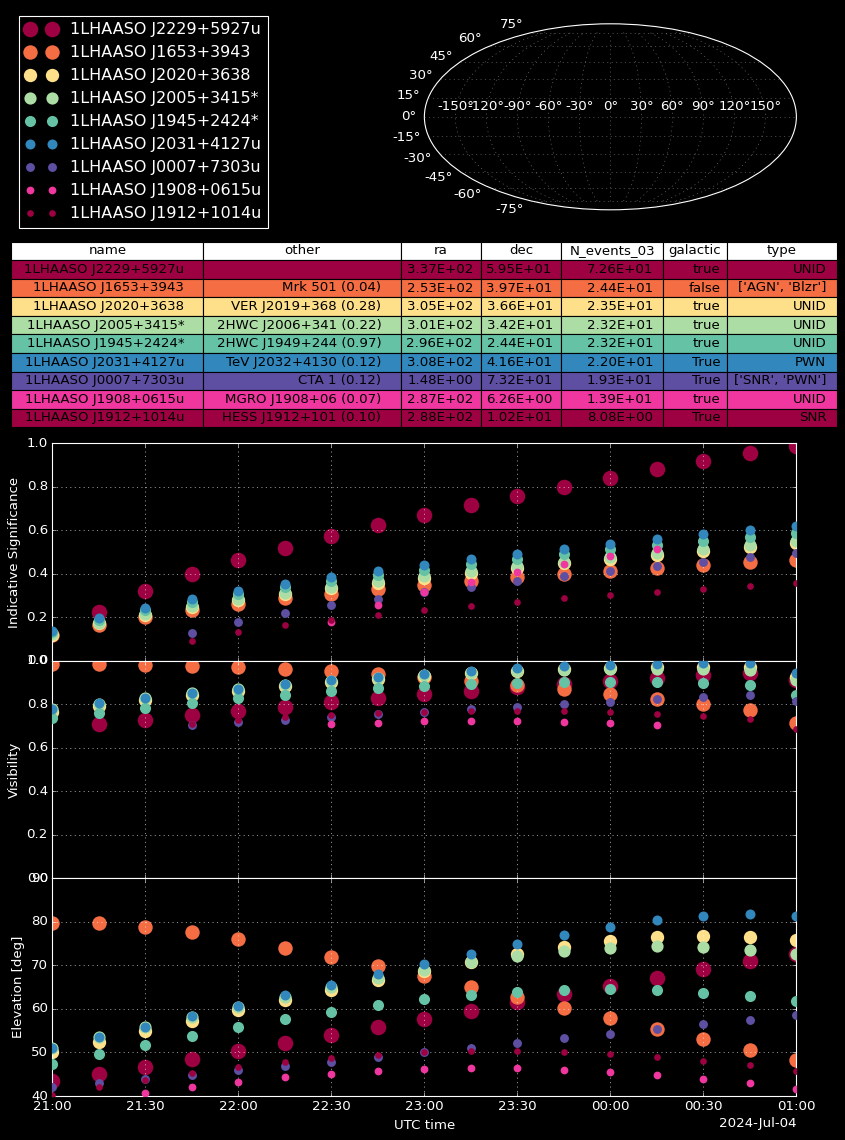

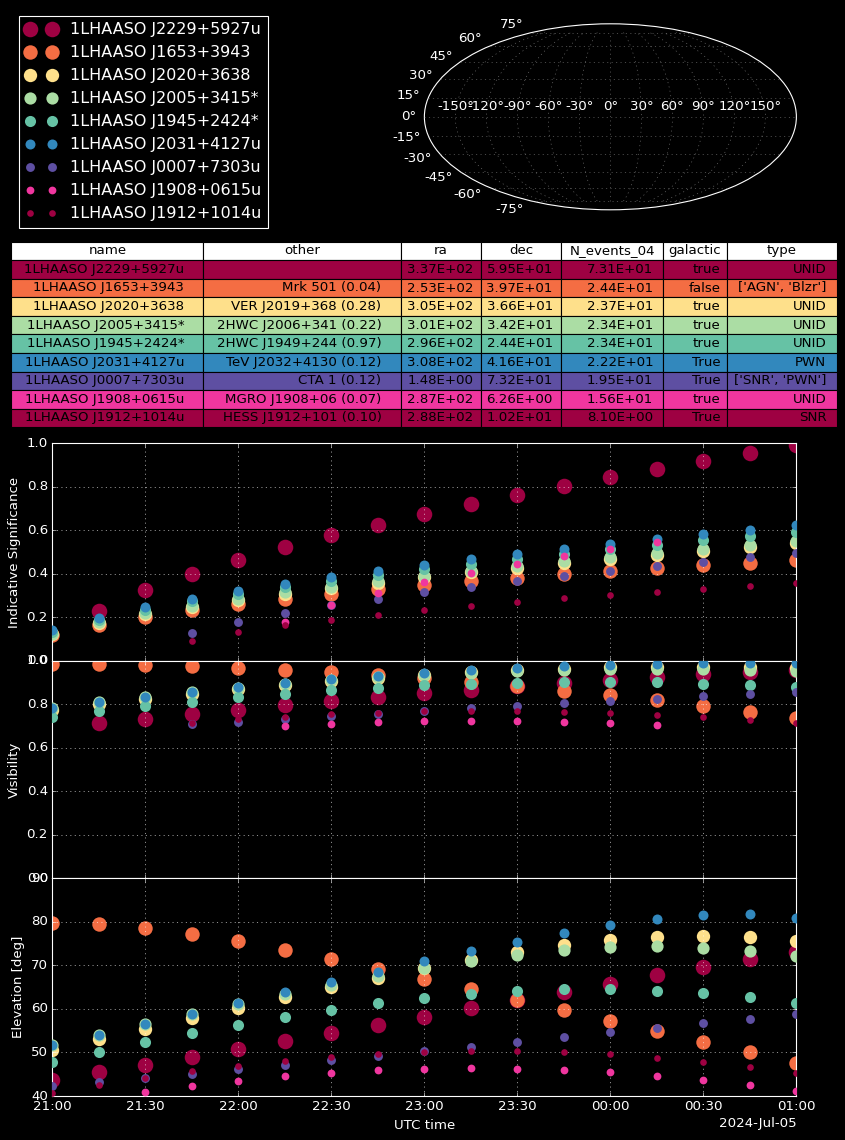

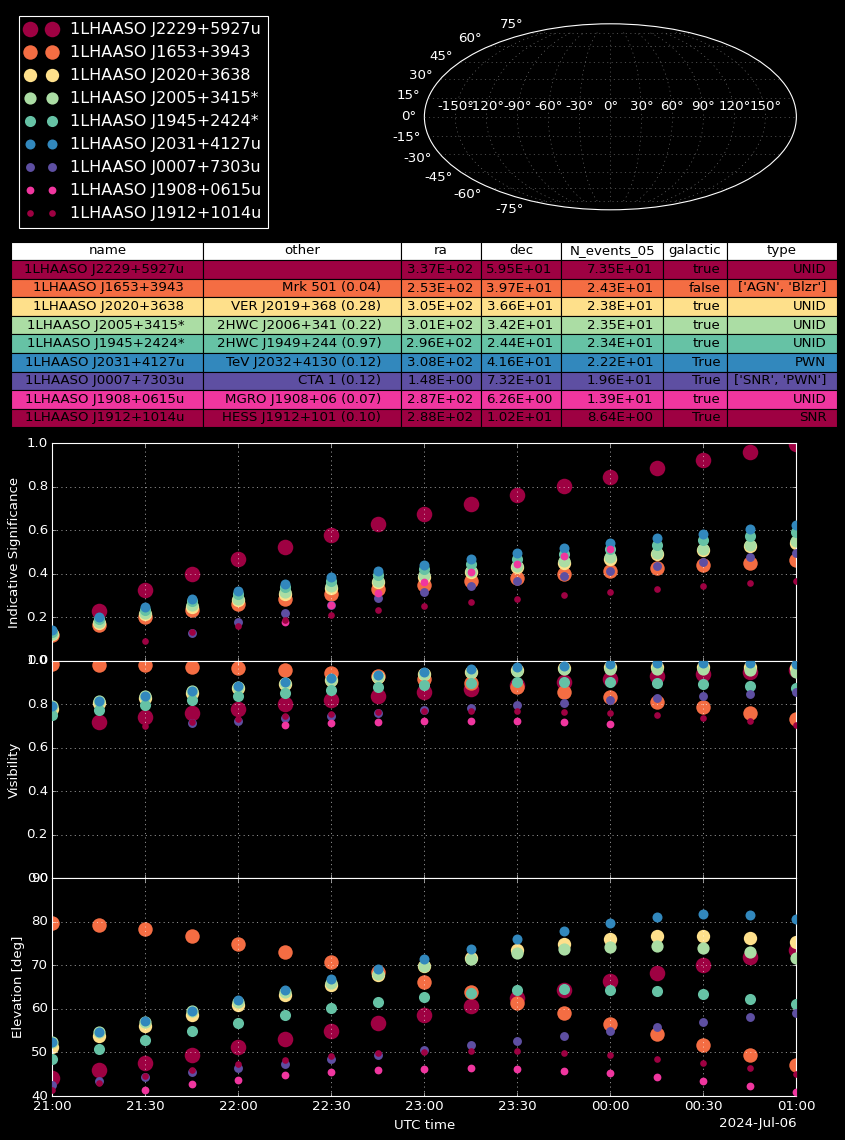

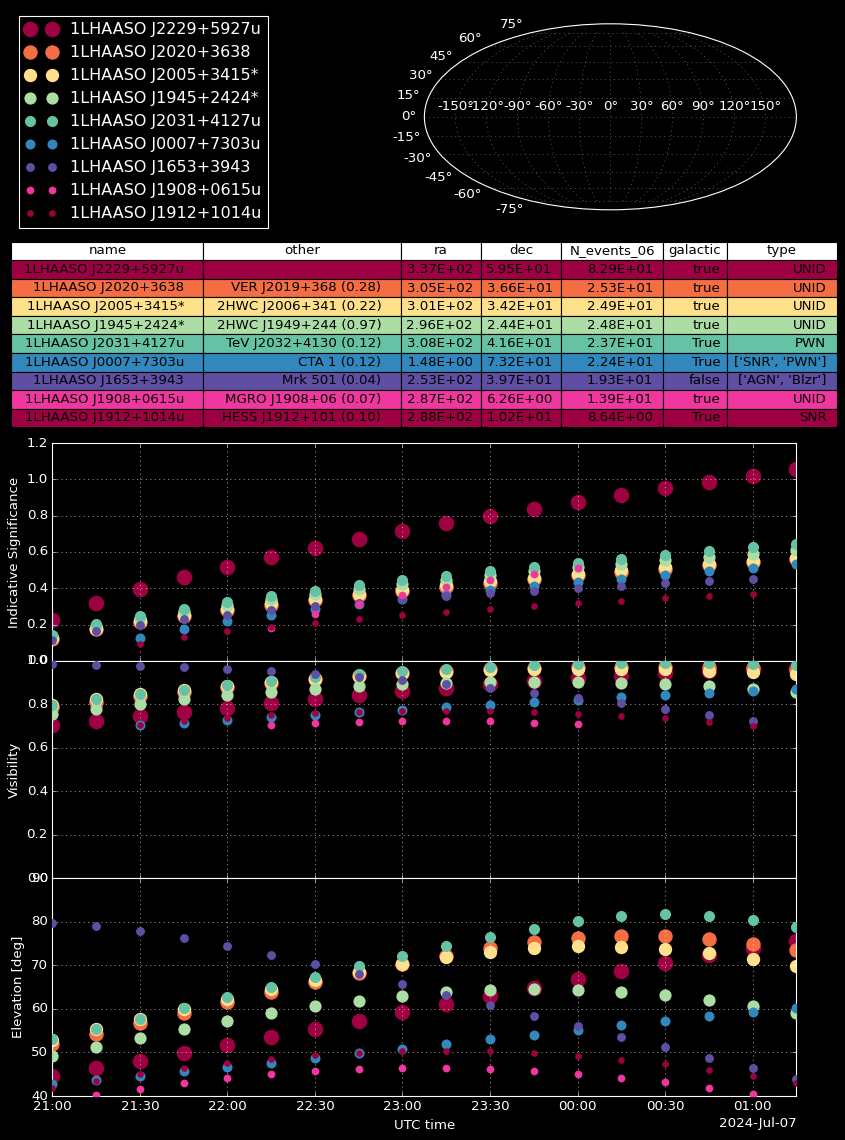

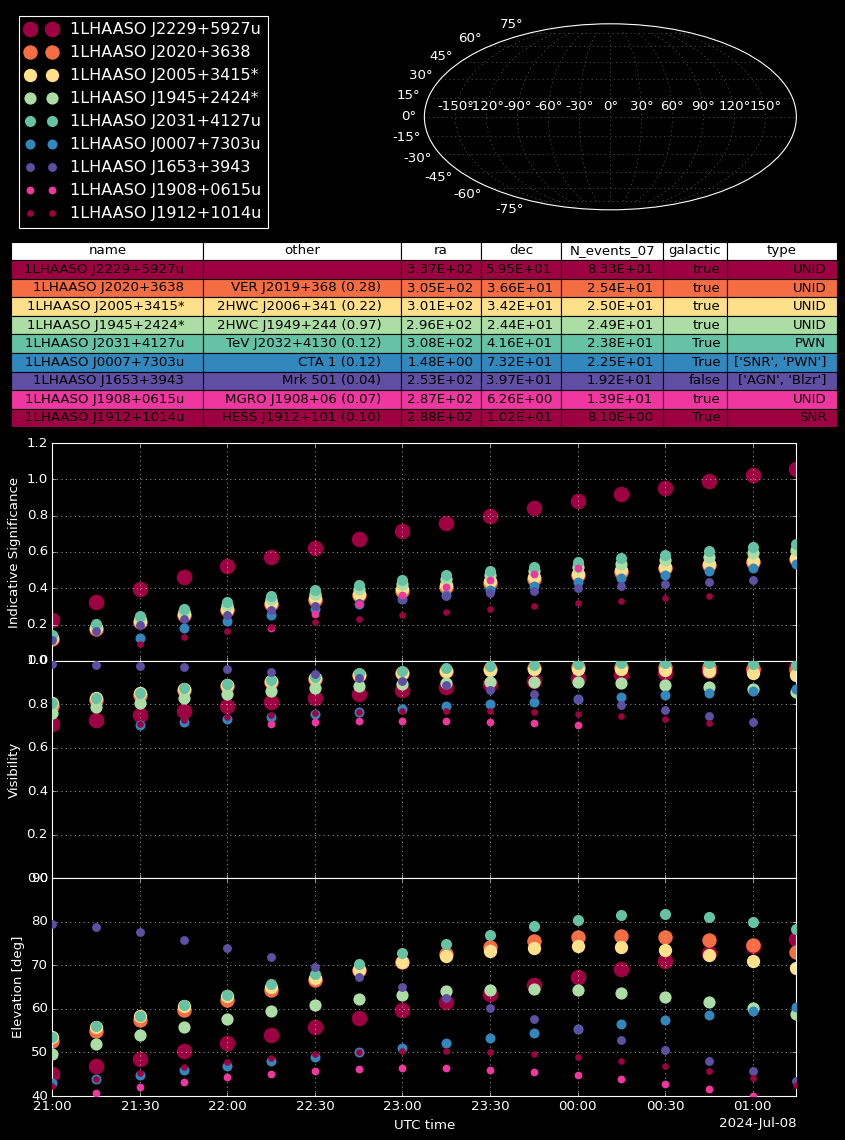

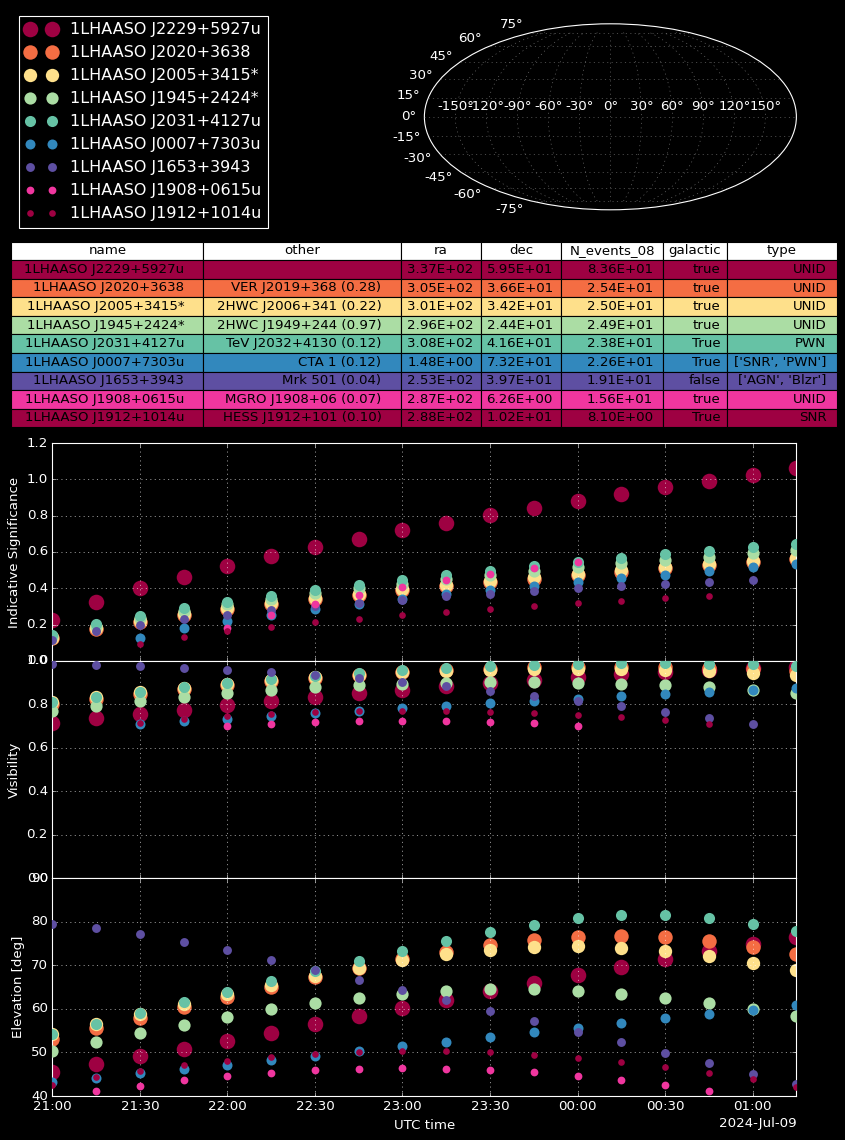

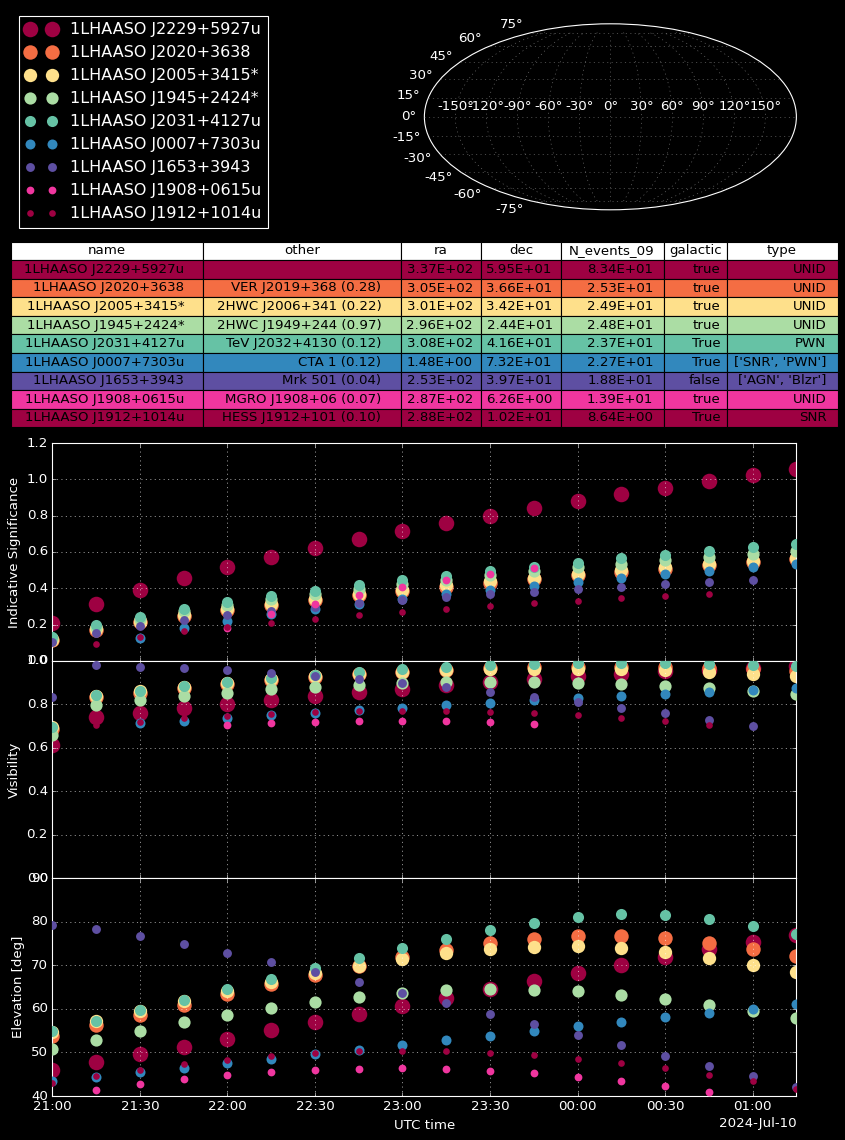

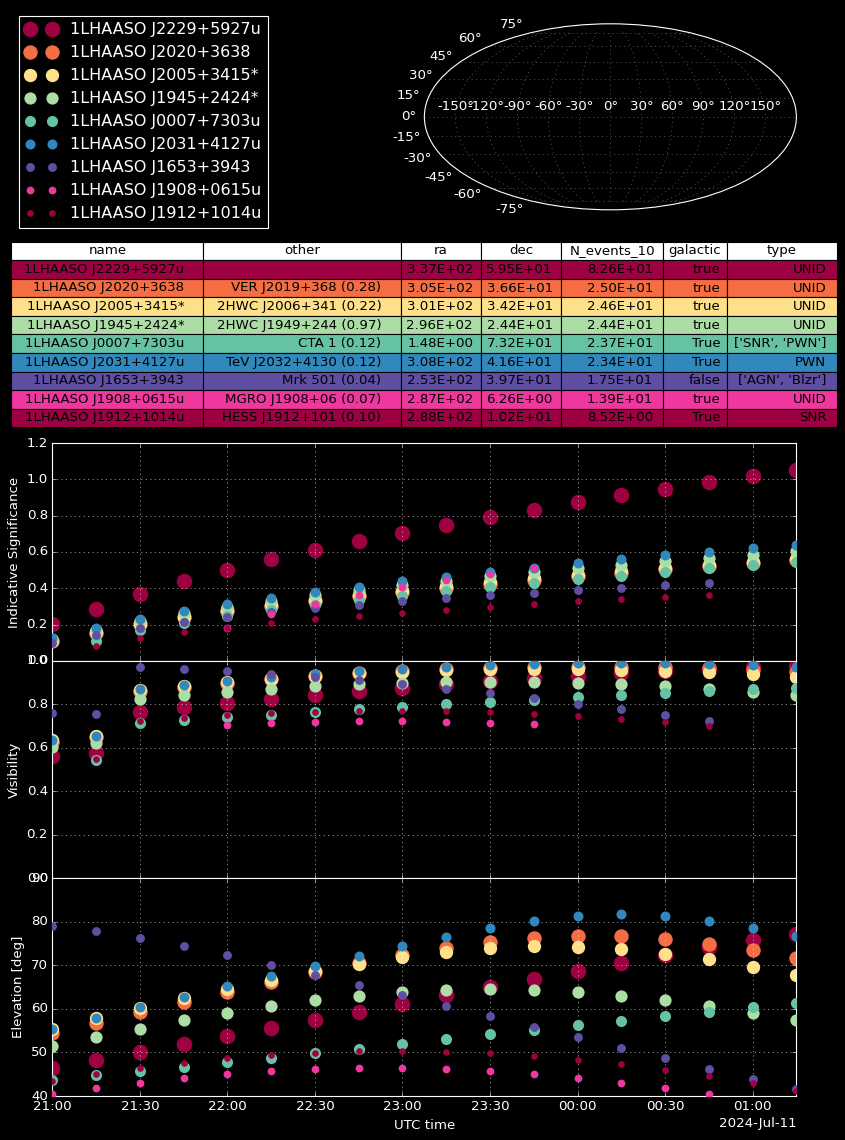

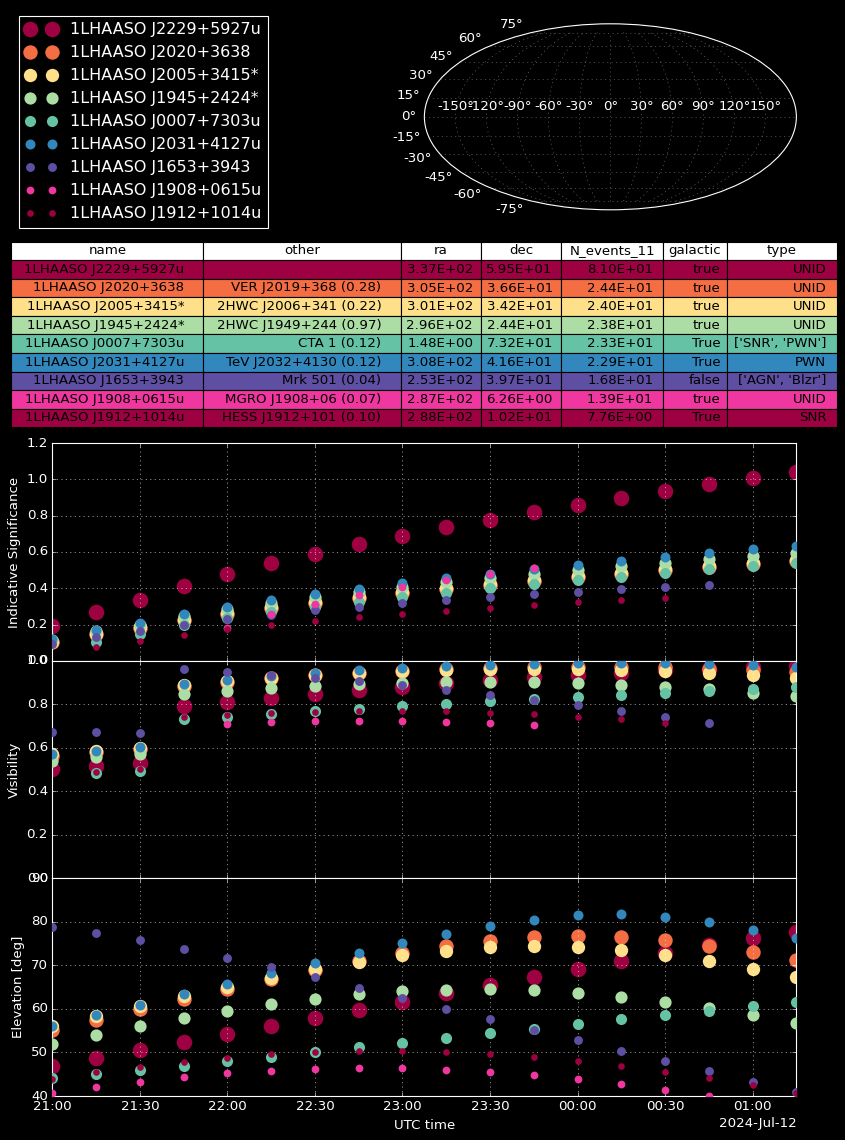

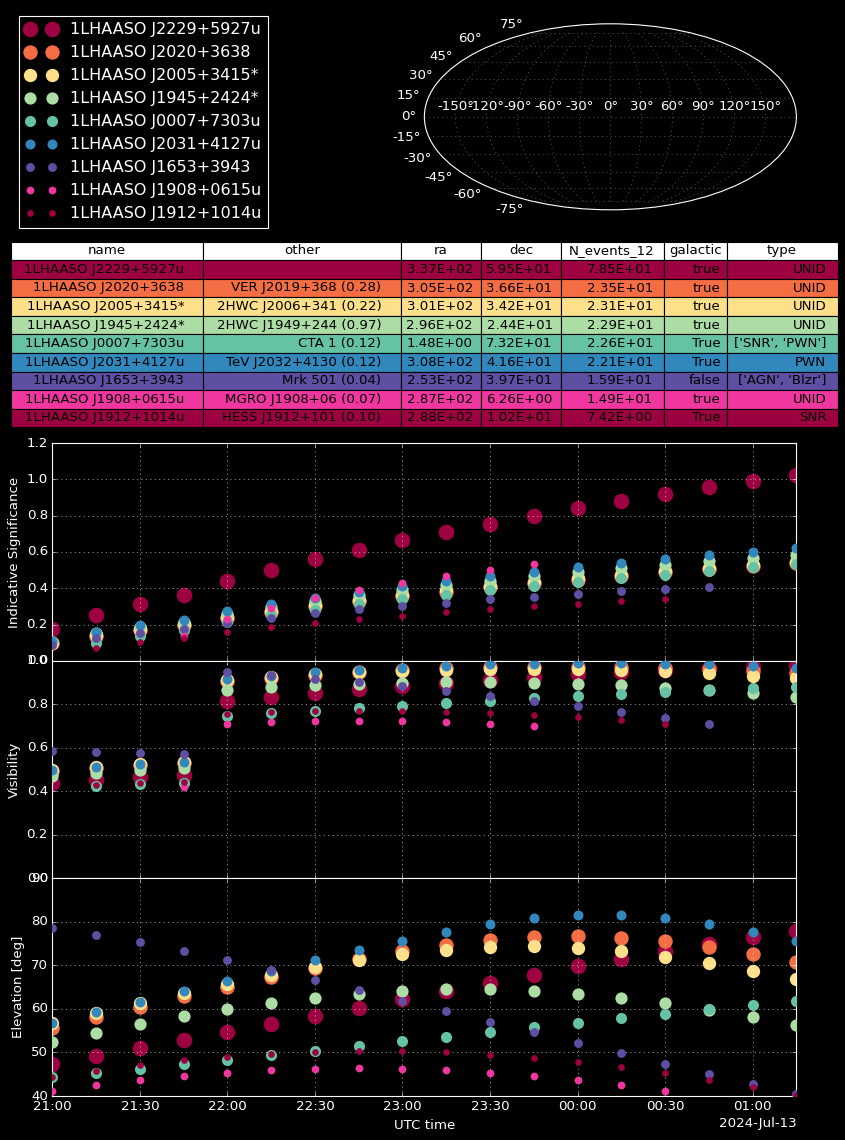

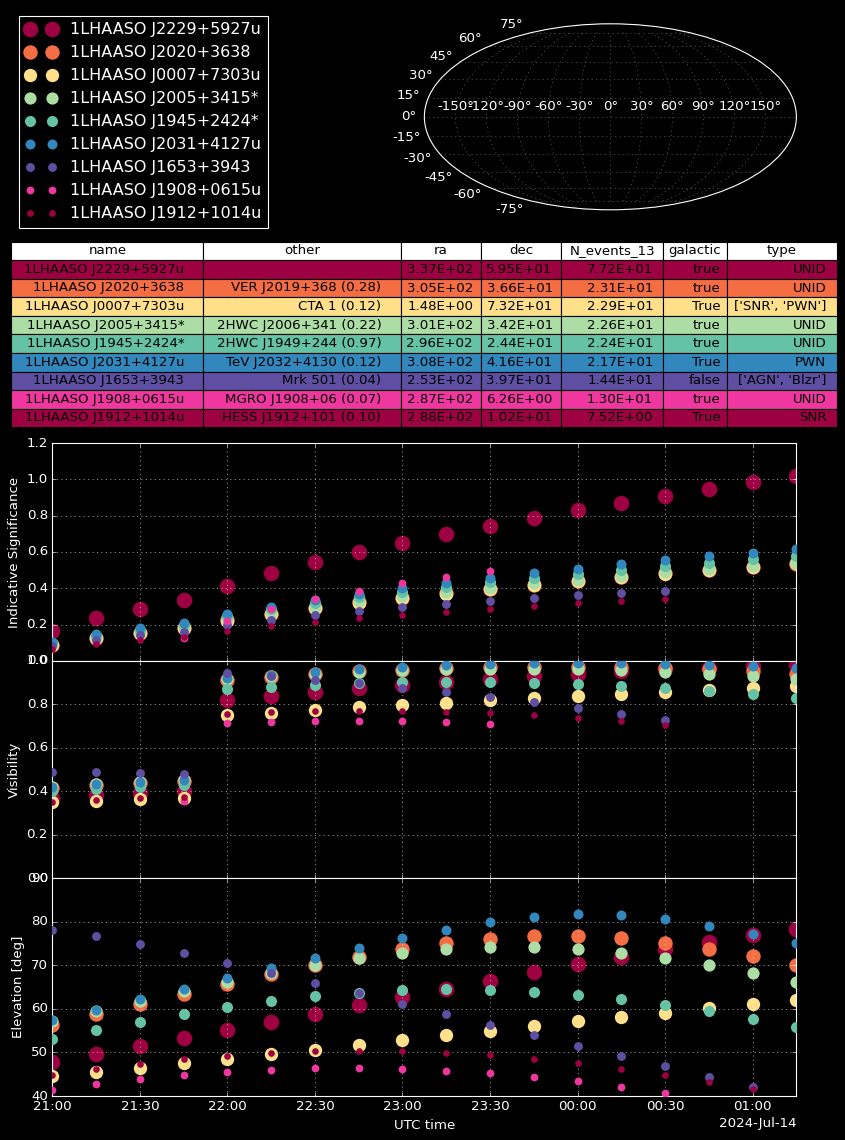

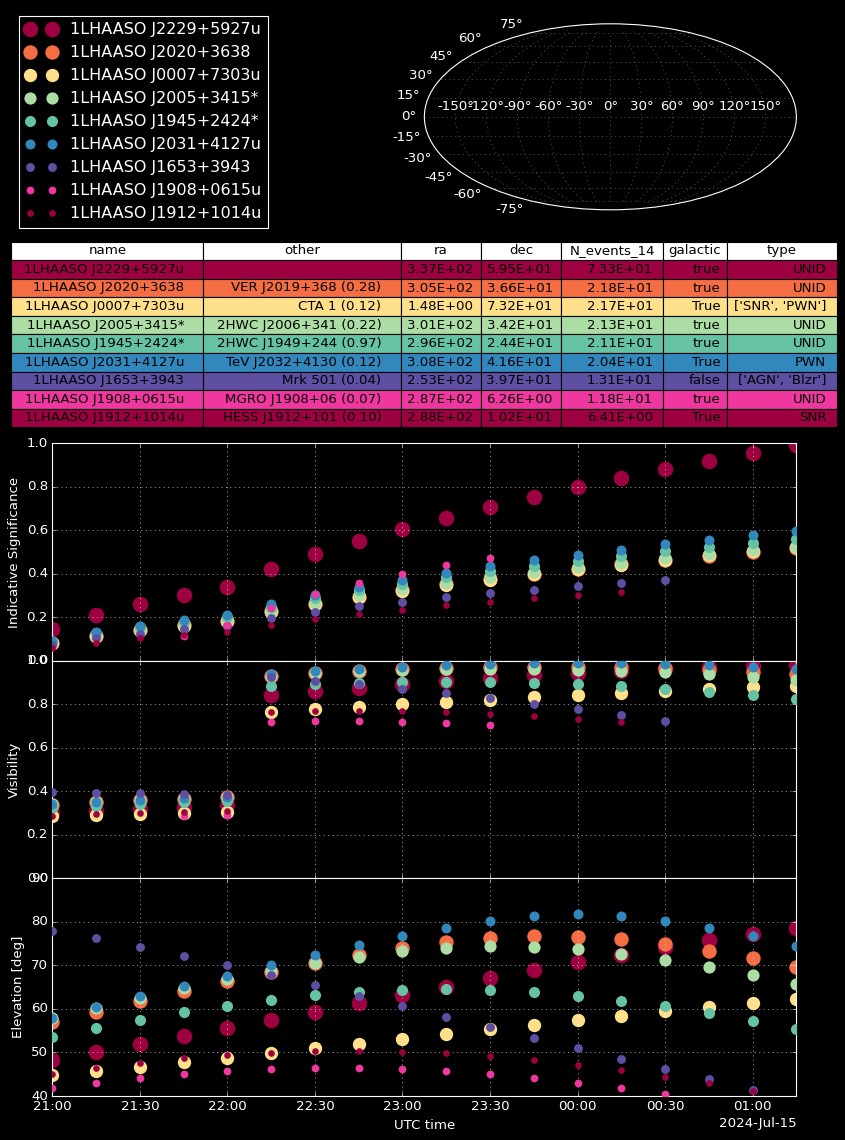

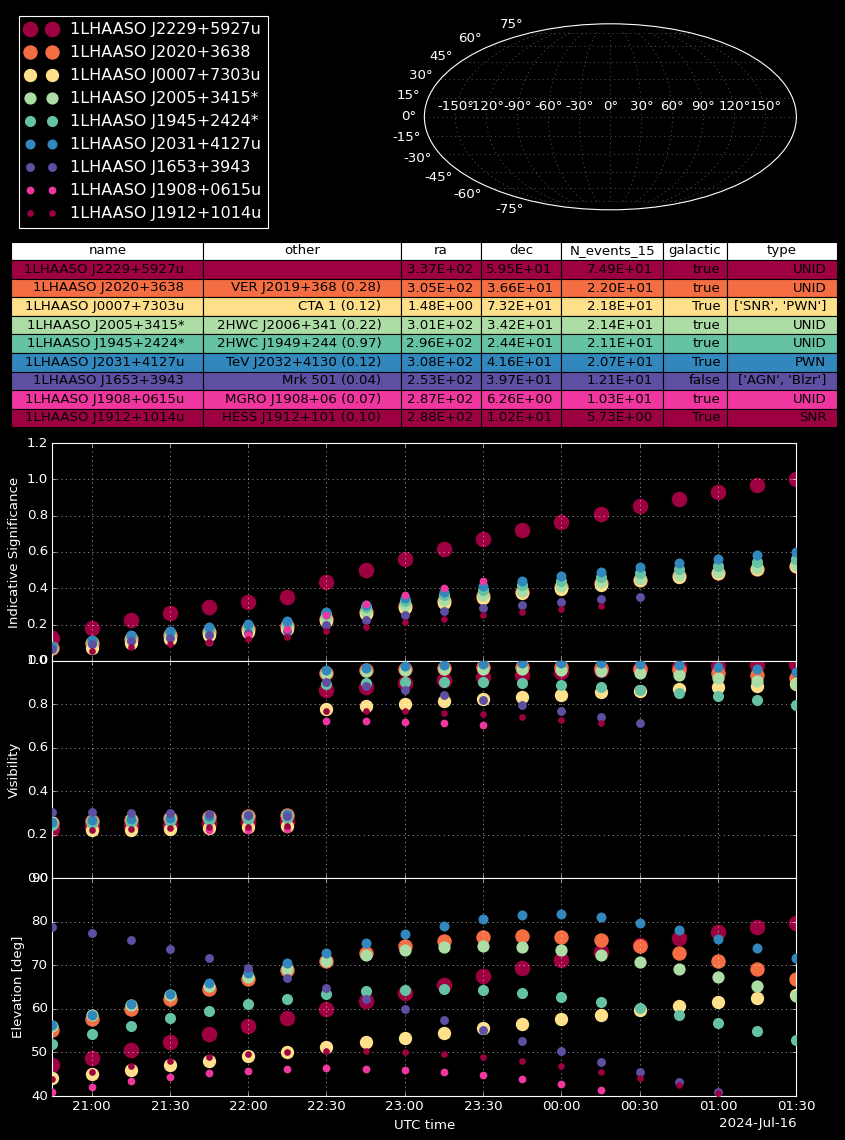

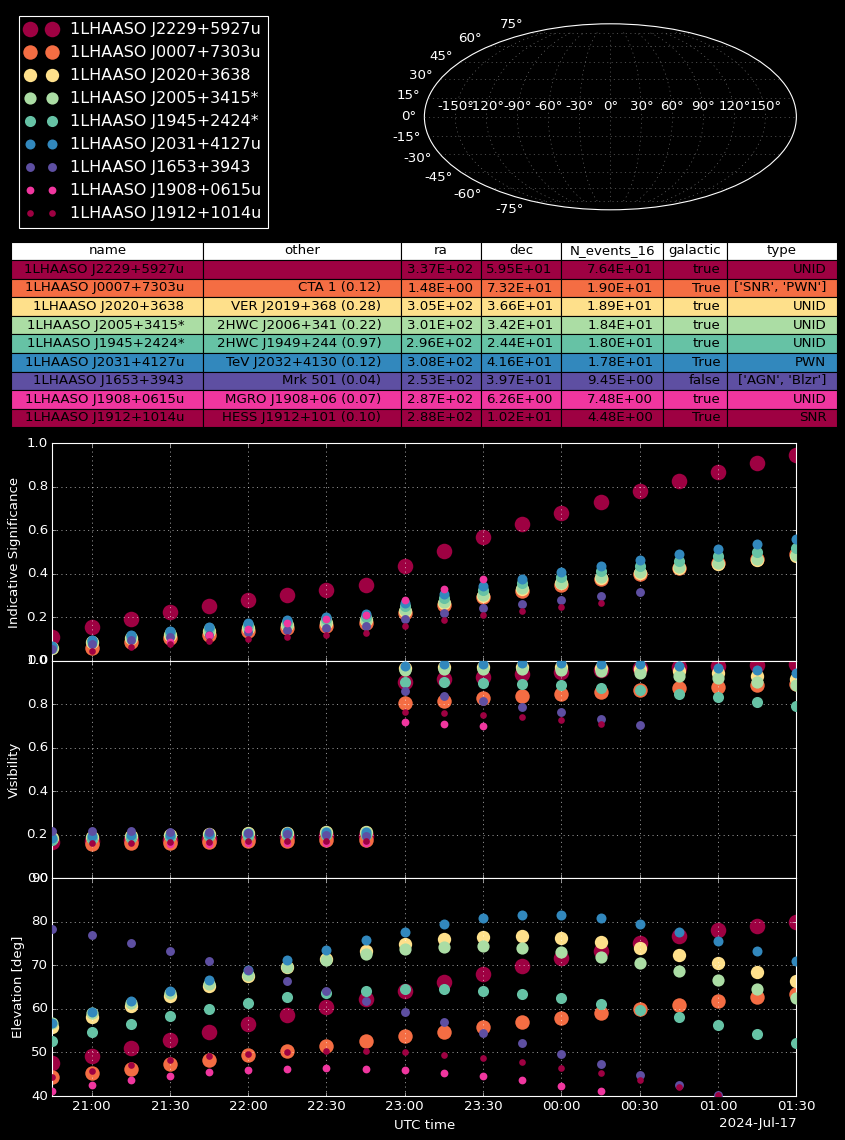

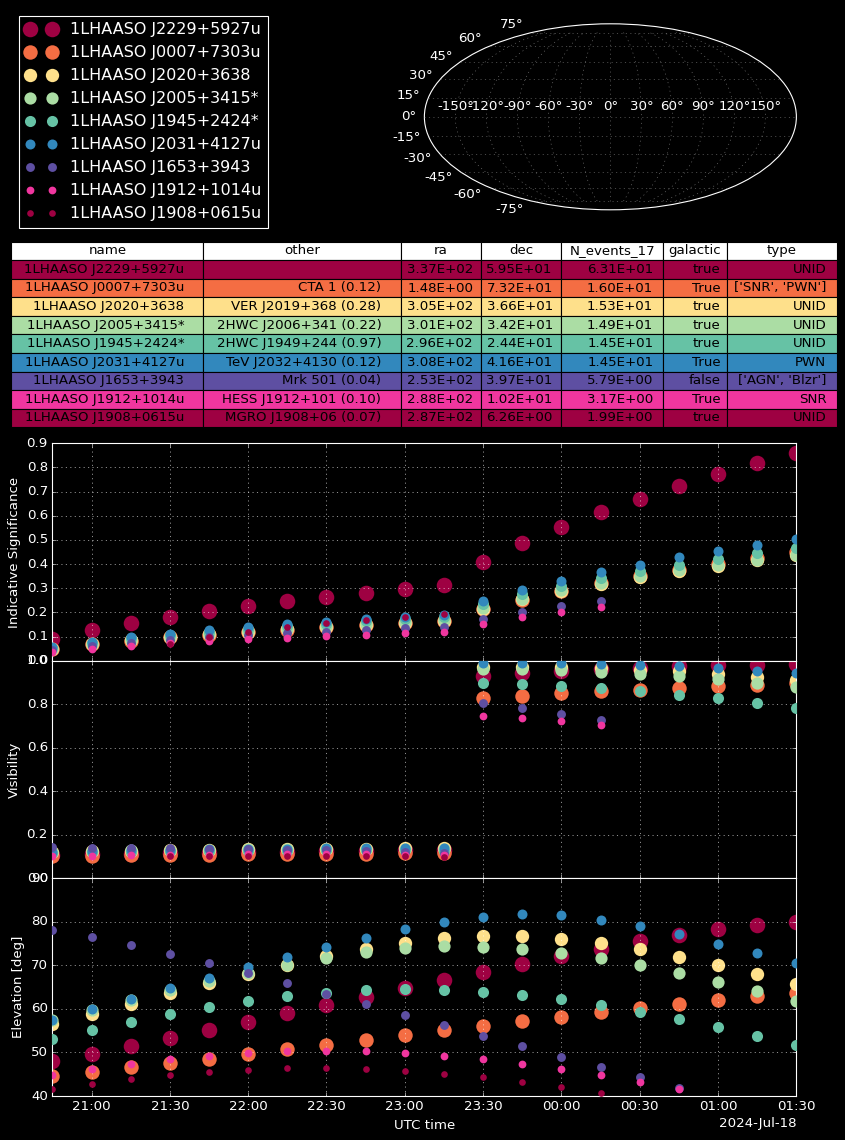

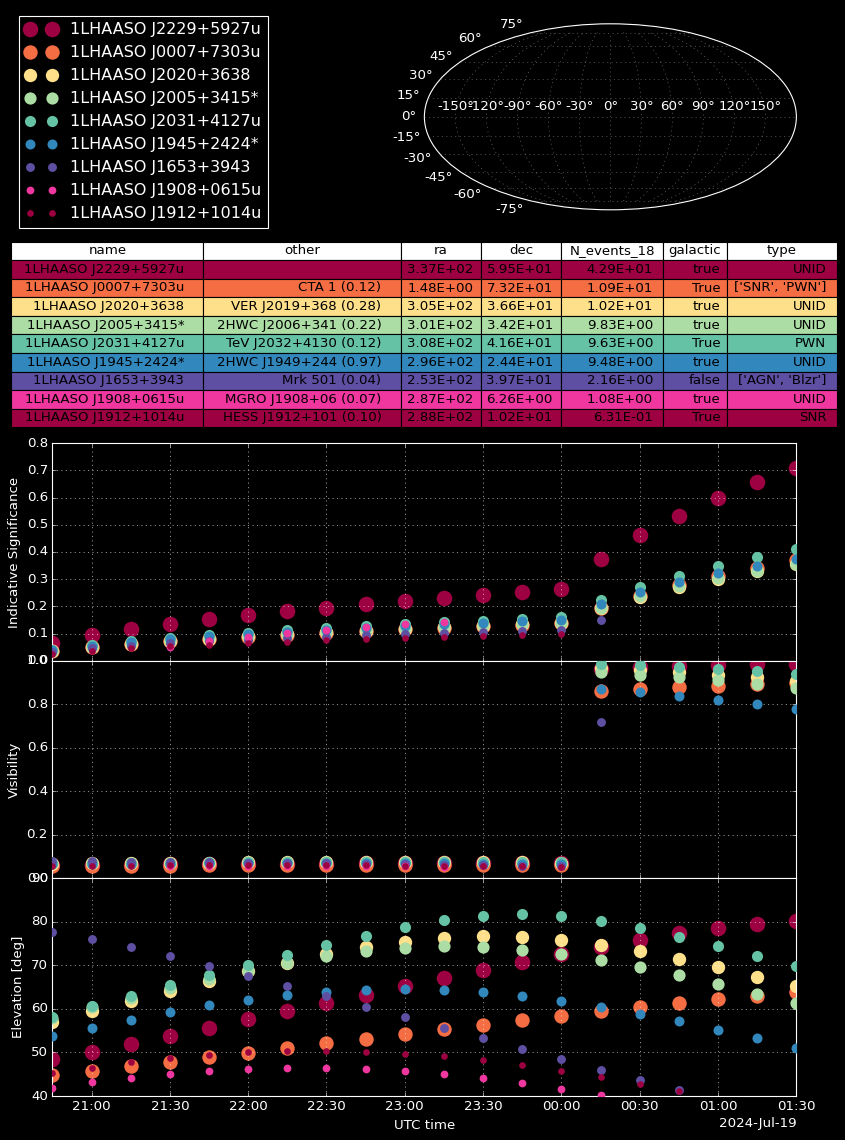

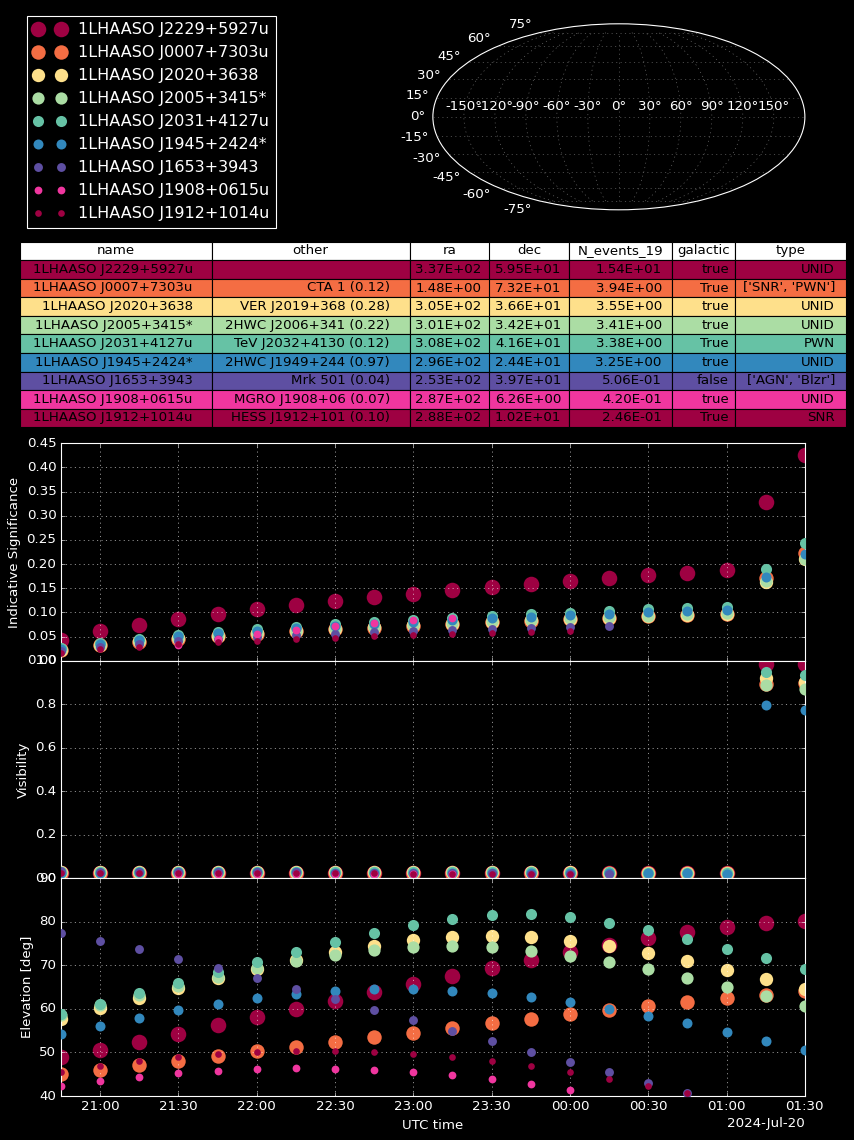

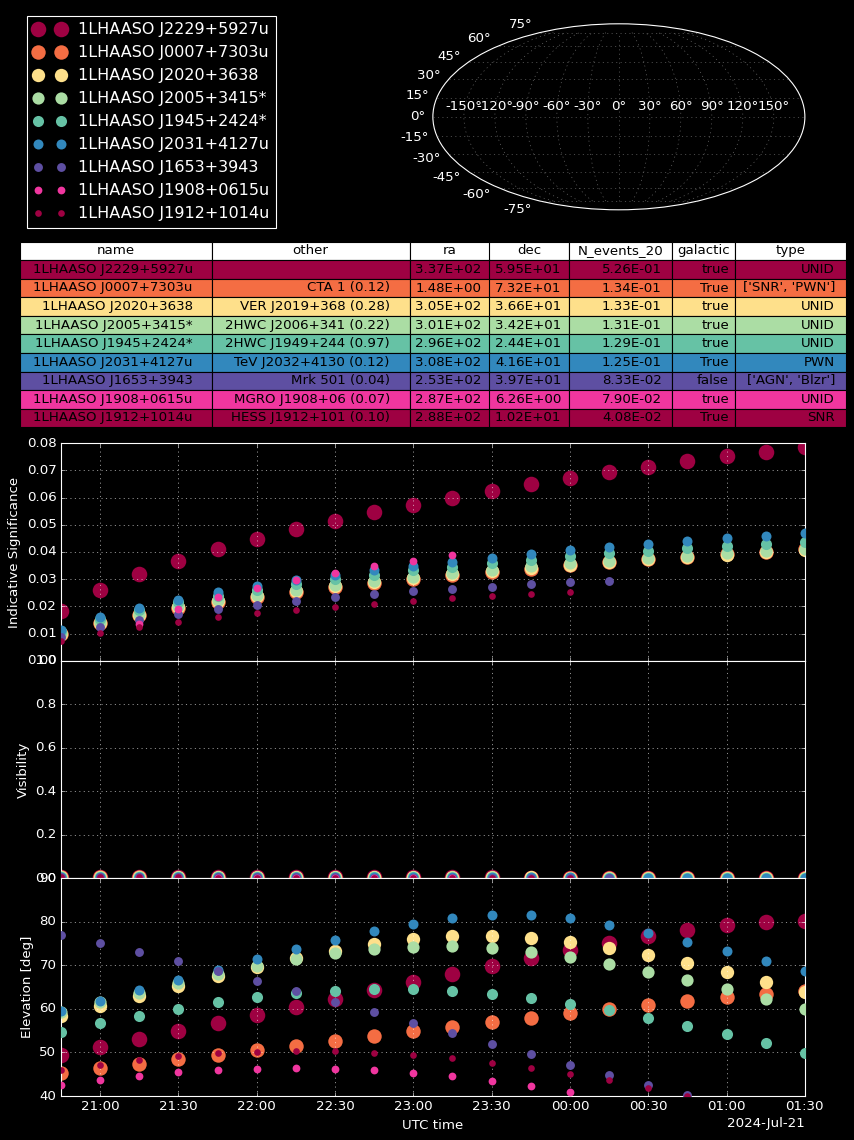

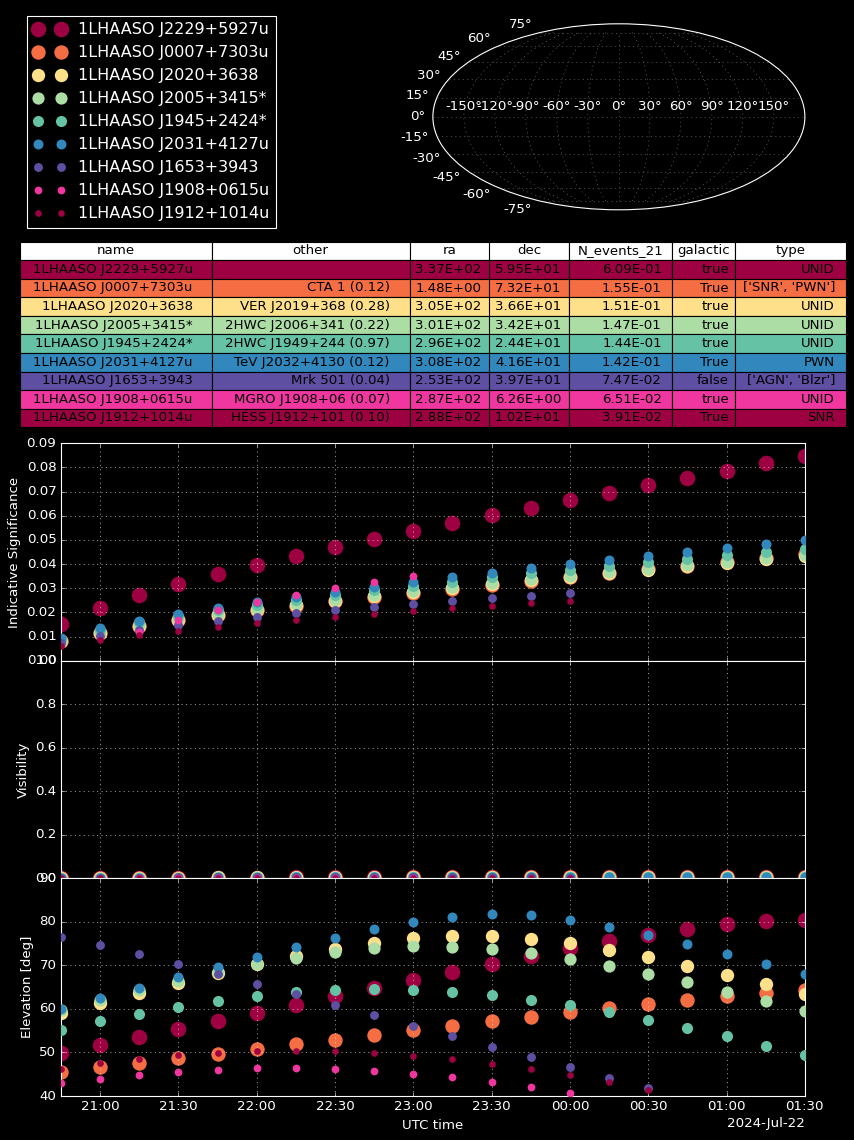

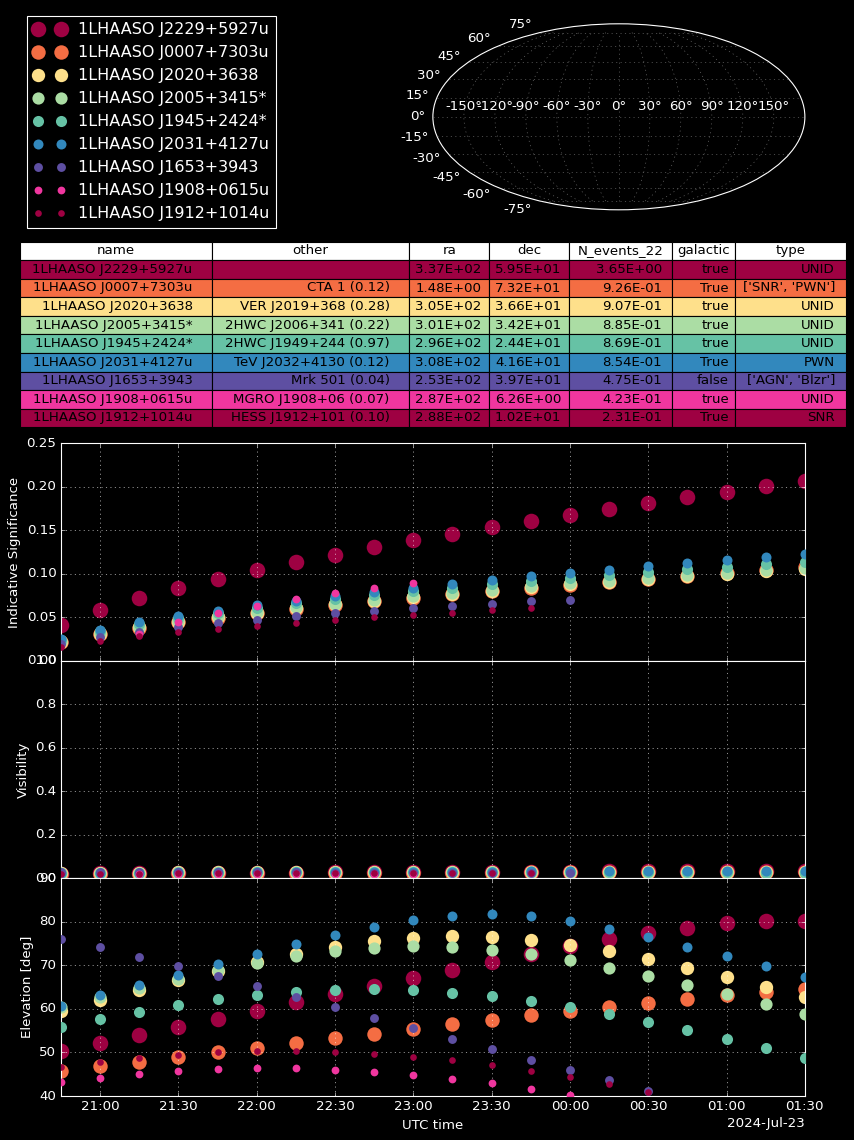

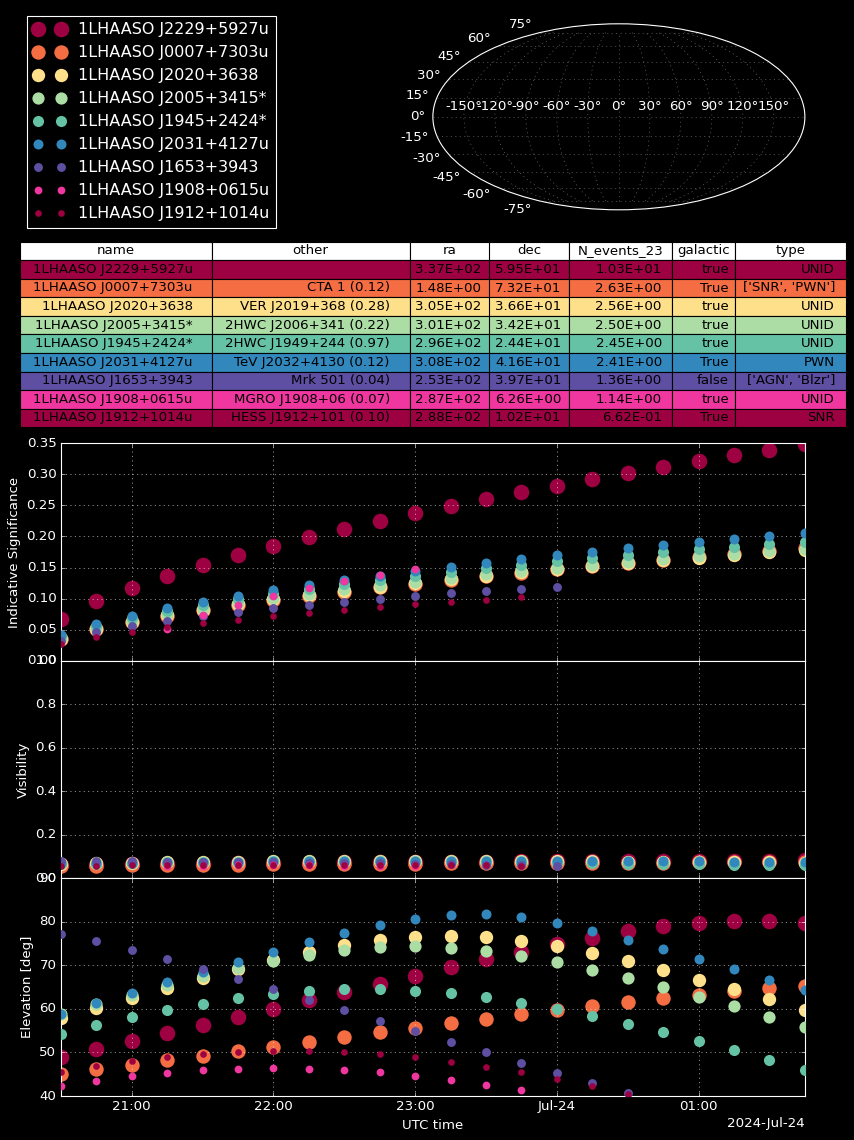

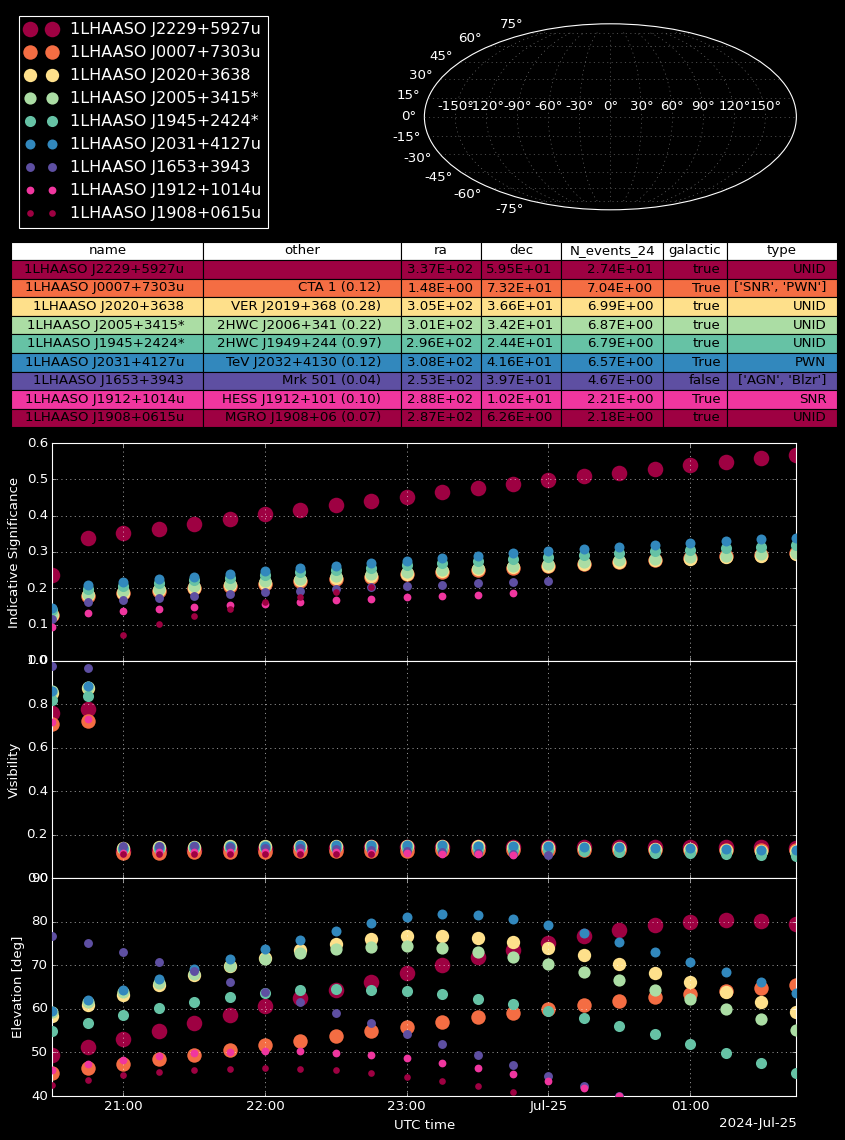

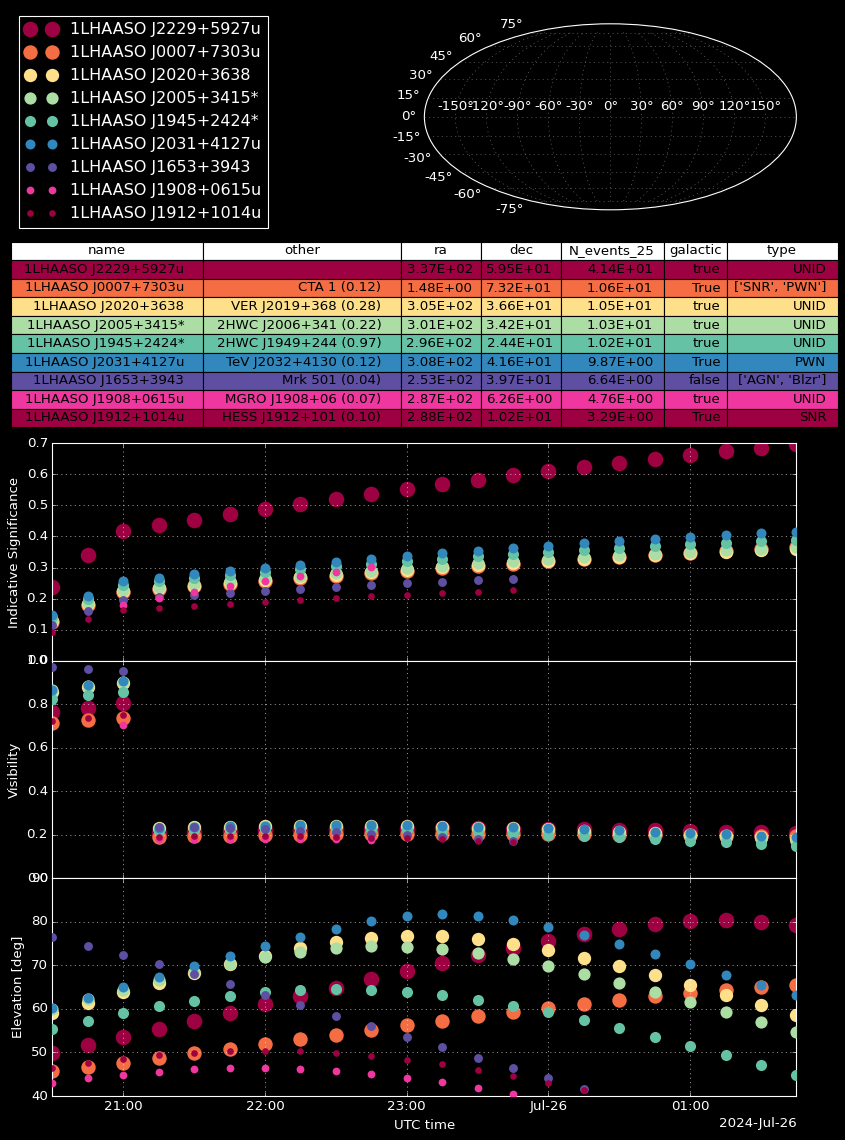

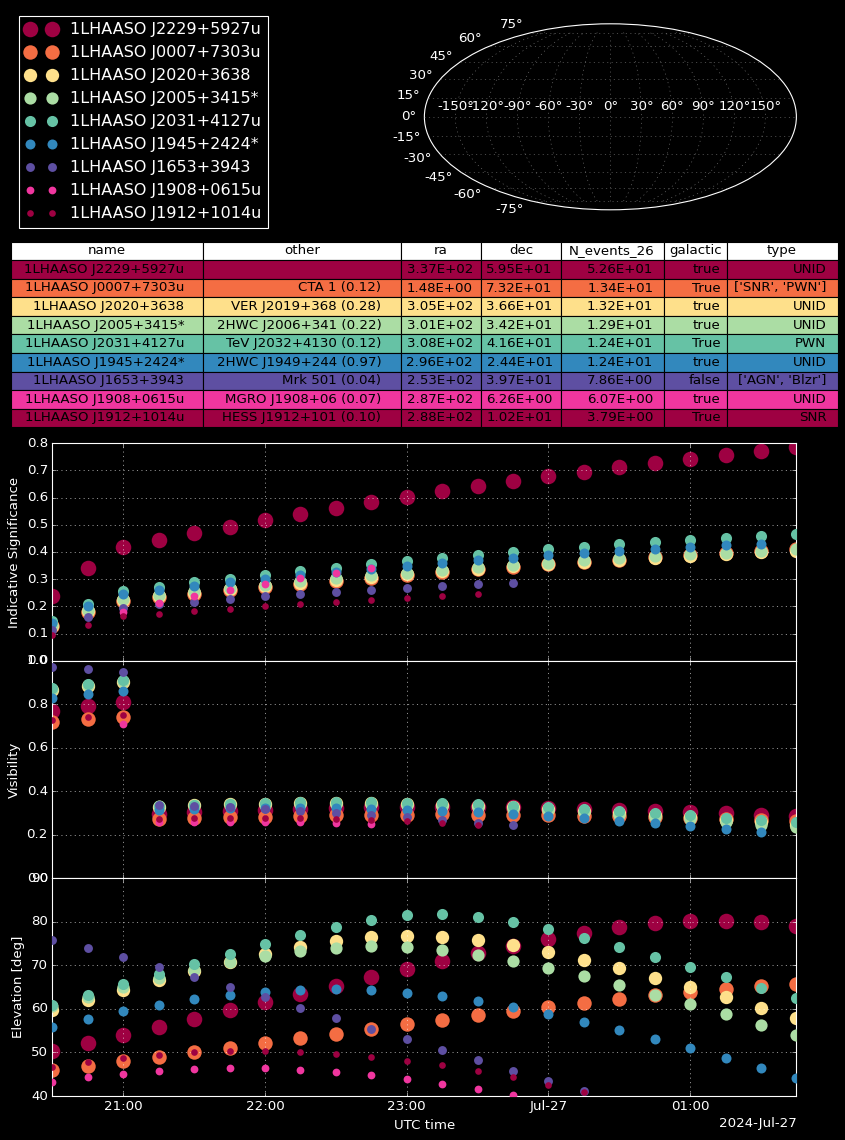

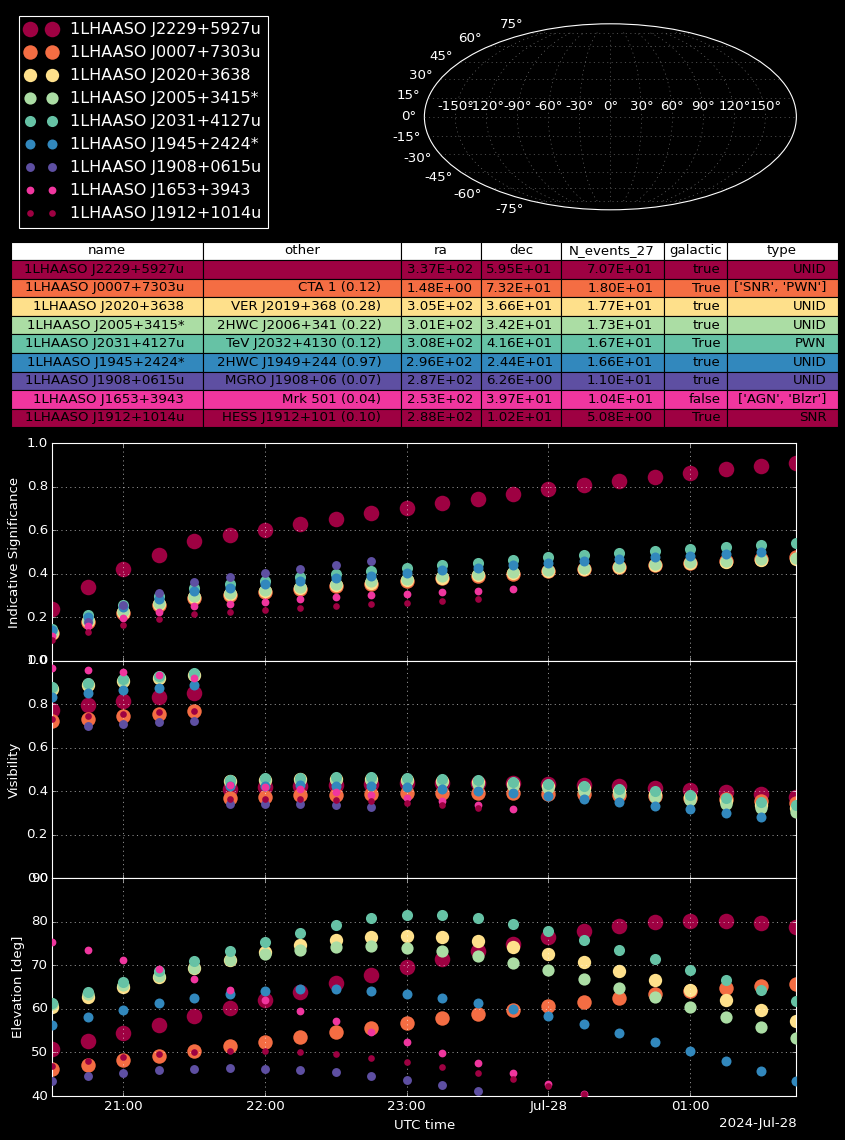

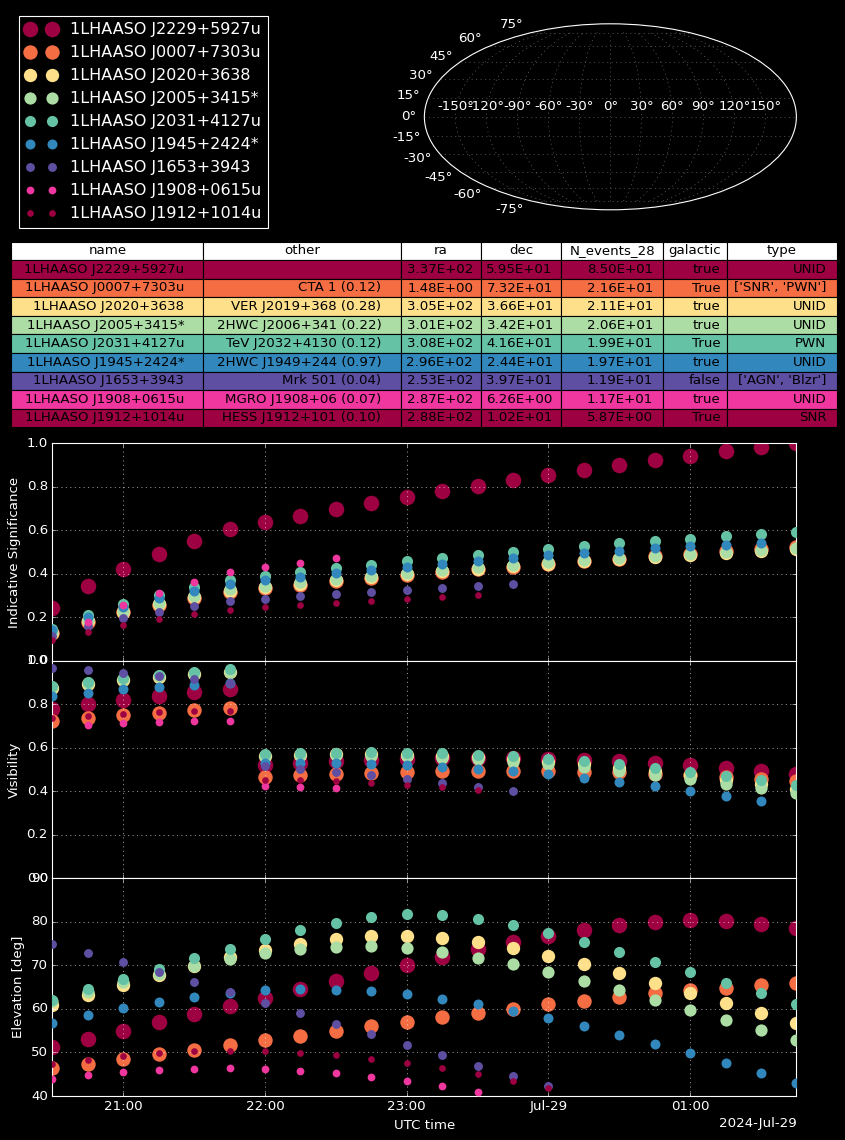

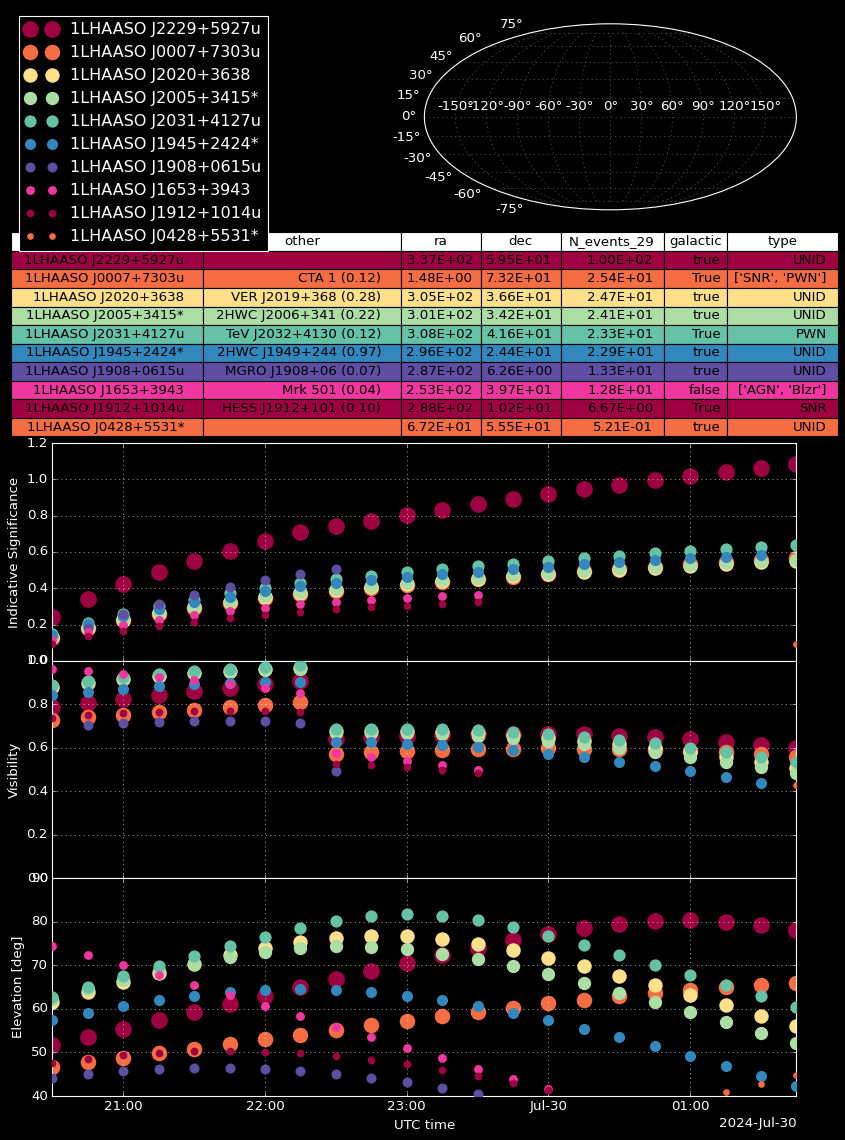

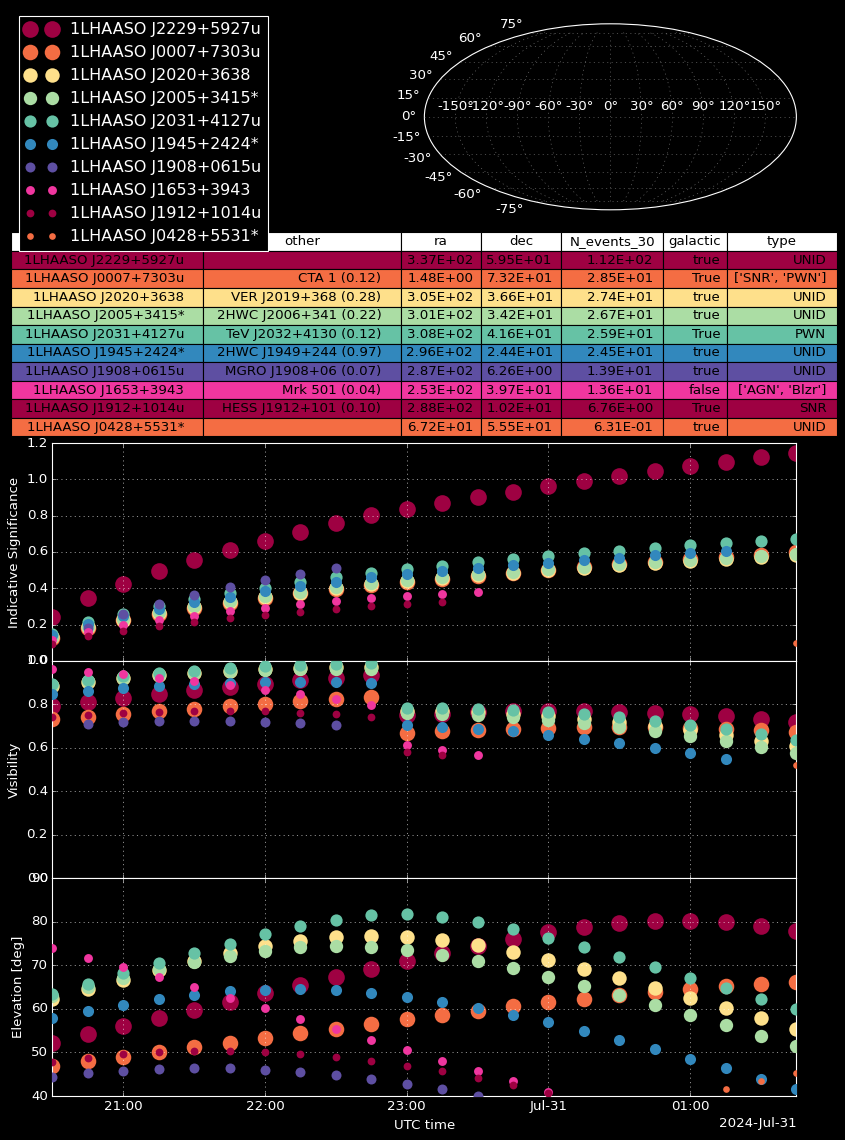

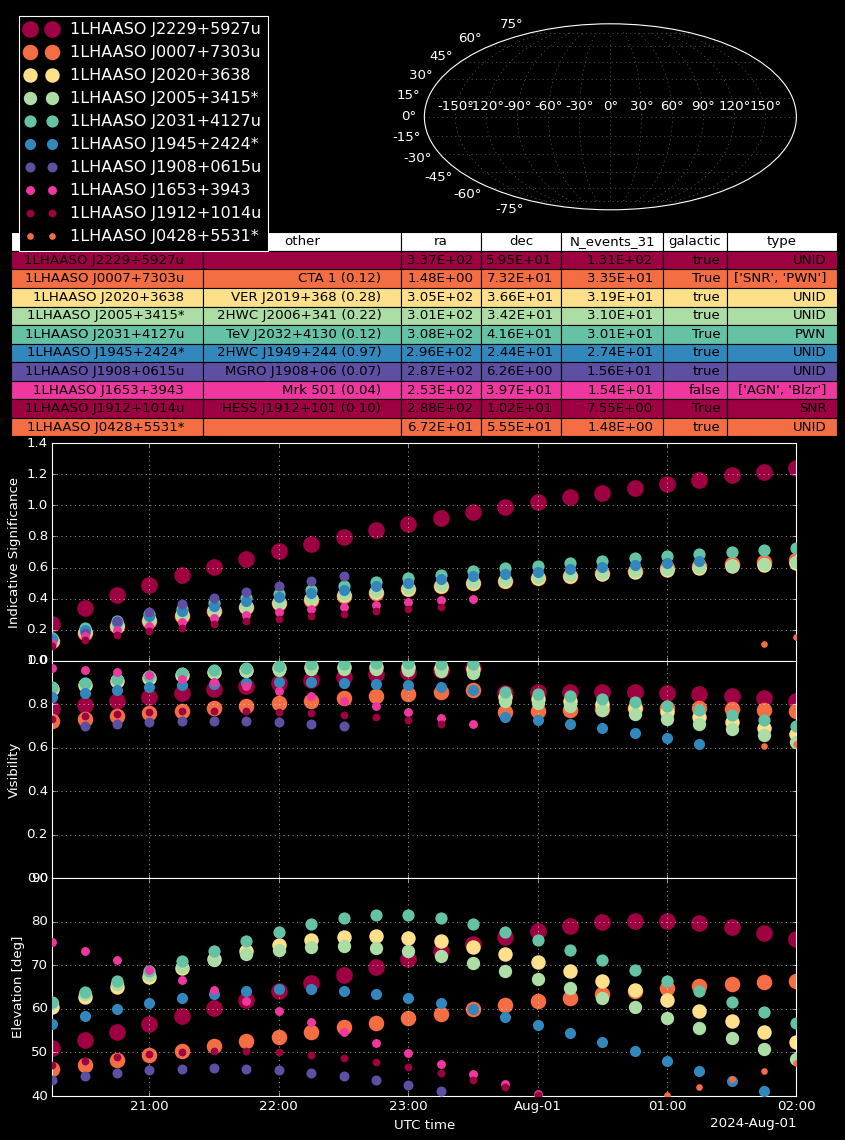

In [26]:
plots_LHAASO(gammacat, m, last)